# Online Portfolio Management 'py the dip'
Notebook by Tobias Kessel (https://www.linkedin.com/in/tobias-kessel-045806b5/)
and Negah Bremer

__This project aims to implement a self regulating portfolio manger__  
This is the source code of all work done for the project
Please see the thesis for further explanation

In [ ]:
# Must be executed once after colab notebook has been opened for the first time!
!pip install yfinance

In [ ]:
# Dependencies
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import timeit
from os import name, system
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from joblib import dump, load


# For all data operations
from google.colab import drive
drive.mount('/drive')

import itertools

Mounted at /drive


In [ ]:
# Support Functions

def get_yfin_data(date_out,select_tickers,delta=60,date_in=None):
  ''''
  Loads stock data from YFINANCE
  --------
  Parameters:
  date_in: Start date of import
  date_out: Stop date of import
  select_tickers: List of tickers to load. Must be YFINANCE compatible
  delta: Time delta if date_in is not set
  --------
  Returns:
  Dataframe with stock data concatenated along axis 0
  ''''
  t_start=timeit.default_timer()
  date_out=dt.datetime.strptime(date_out,'%Y-%m-%d')
  if date_in == None:
    date_in=date_out - dt.timedelta(days=delta)
  else:
    date_in=dt.datetime.strptime(date_in,'%Y-%m-%d')
  print('Getting YFinance Data. Date-in:',date_in.strftime('%Y-%m-%d'), 'Date-out:',date_out.strftime('%Y-%m-%d'))
  print('--------------------------------------------------------------------')

  yfin_data=pd.DataFrame()
  for ticker in select_tickers:
    print(ticker)
    yfin=yf.Ticker(ticker)
    # Get ticker data
    hist=yfin.history(start=date_in,end=date_out)
    hist['Ticker']=ticker
    yfin_data=pd.concat((yfin_data,hist),axis=0)
  yfin_data=yfin_data.reset_index()
  yfin_data['Date']=pd.to_datetime(yfin_data['Date']).dt.strftime('%Y-%m-%d')
  t_stop=timeit.default_timer()
  runtime=round(t_stop-t_start,2)
  print("Finished getting YFinance Data!")
  print(f'Runtime: {runtime}s')
  print('--------------------------------------------------------------------')
  # Fill returner with closing value of dataset
  return yfin_data

def save_csv_df(df,name):
  ''''
  Saves a dataframe to folder DATASETS
  --------
  Parameters:
  df: Dataframe containing the data to save
  name: Filename of the saved file
  ''''
  drive.mount('/drive')
  df.to_csv('/drive/My Drive/OPA/Datasets/'+ name +'.csv')

def load_csv_df(name):
  ''''
  Loads a dataframe from folder DATASETS
  --------
  Parameters:
  name: Filename of the file to load
  ''''
  drive.mount('/drive')
  df_load=pd.read_csv('/drive/My Drive/OPA/Datasets/'+ name +'.csv',index_col='Index')
  return df_load

In [ ]:
# DICT of all tickers to use with abbreviated and clear names

tickers = {'AAPL':'Apple','MSFT':'Microsoft',
                'AMZN':'Amazon','BRK-B':'Berkshire Hathaway',
                'UNH':'UnitedHealth','JNJ':'Johnson & Johnson',
                'V':'VISA','TSM':'TSMC','NVDA':'NVIDIA','XOM':'Exxon Mobile',
                'WMT':'Walmart','PG':'Procter & Gamble','JPM':'JPMorgan Chase',
                'MA':'Mastercard','HD':'Home Depot'}

# *CLASS stock_feature_generator()

In [ ]:
# Classes & Functions for the rolling avg and marker calculation

class stock_feature_generator(TransformerMixin,BaseEstimator):
  ''''
  Creates additional features of a given stock-df
  --------
  Parameters:
  threshold: Range 0 - 1. Is used to determine which deviation between
             rolling avg and Closing price are acceptable.
             Markers are set where threshold +- is exceeded
  ticker:    Which ticker to select out of the input dataset  
  ''''
  
  def __init__(self,threshold=0.1,ticker=None):
    self.df=[]
    self.threshold=threshold
    self.ticker=ticker

  def add_ra_10(self):
    '''
    Add a rolling average of 10 days for closing price
    '''
    self.df['rolling_Close_10d']=self.df['Close'].rolling(window=10).mean()

  def add_ra_20(self):
    '''
    Add a rolling average of 20 days for closing price
    '''
    self.df['rolling_Close_20d']=self.df['Close'].rolling(window=20).mean()

  def add_threshold_under_10(self):
    '''
    Add a marker if rolling average 10d is below CLOSE by given threshold
    '''
    self.df.loc[:,'Close_rel_roll_avg_10d']=(self.df['Close']-self.df['rolling_Close_10d'])/self.df['rolling_Close_10d']
    self.df.loc[:,'threshold_under_10d']=[1 if x < -self.threshold else 0 for x in self.df['Close_rel_roll_avg_10d']]

  def add_threshold_under_20(self):
    '''
    Add a marker if rolling average 20d is below CLOSE by given threshold
    '''
    self.df.loc[:,'Close_rel_roll_avg_20d']=(self.df['Close']-self.df['rolling_Close_20d'])/self.df['rolling_Close_20d']
    self.df.loc[:,'threshold_under_20d']=[1 if x < -self.threshold else 0 for x in self.df['Close_rel_roll_avg_20d']]

  def add_threshold_over_10(self):
    '''
    Add a marker if rolling average 10d is above CLOSE by given threshold
    '''
    self.df.loc[:,'Close_rel_roll_avg_10d']=(self.df['Close']-self.df['rolling_Close_10d'])/self.df['rolling_Close_10d']
    self.df.loc[:,'threshold_over_10d']=[1 if x > self.threshold else 0 for x in self.df['Close_rel_roll_avg_10d']]

  def add_threshold_over_20(self):
    '''
    Add a marker if rolling average 10d is above CLOSE by given threshold
    '''
    self.df.loc[:,'Close_rel_roll_avg_20d']=(self.df['Close']-self.df['rolling_Close_20d'])/self.df['rolling_Close_20d']
    self.df.loc[:,'threshold_over_20d']=[1 if x > self.threshold else 0 for x in self.df['Close_rel_roll_avg_20d']]

  def add_intersect(self):
    '''
    Difference between Close and rolling average 10 & 20d
    '''
    self.df.loc[:,'C_rav_intersect_10d']=self.df['Close']-self.df['rolling_Close_10d']
    self.df.loc[:,'C_rav_intersect_20d']=self.df['Close']-self.df['rolling_Close_20d']

  def add_intersect_marker_10d(self):
    '''
    Add a marker if C_rav_intersec has a change in sign
    '''
    self.df.loc[:,'Close_10d_intersect_marker']=np.nan
    start_index=self.df.index[0]
    for i in self.df.index:
      #print(i)
        if i-start_index != 0:
          if (self.df.loc[i,'C_rav_intersect_10d']*self.df.loc[i-1,'C_rav_intersect_10d']) <= 0:
            # Intersect if the sign is <= 0 when doing value_day1*value_day2. This means there was a crossing of the intersection
            self.df.loc[i,'Close_10d_intersect_marker']=1
          else:
            self.df.loc[i,'Close_10d_intersect_marker']=0
        else:
          self.df.loc[i,'Close_10d_intersect_marker']=0

  def add_intersect_marker_20d(self):
    '''
    Add a marker if C_rav_intersec has a change in sign
    '''
    self.df.loc[:,'Close_20d_intersect_marker']=np.nan
    start_index=self.df.index[0]
    for i in self.df.index:
        if i-start_index != 0:
          if (self.df.loc[i,'C_rav_intersect_20d']*self.df.loc[i-1,'C_rav_intersect_20d']) <= 0:
            # Intersect if the sign is <= 0 when doing value_day1*value_day2. This means there was a crossing of the intersection
            self.df.loc[i,'Close_20d_intersect_marker']=1
          else:
            self.df.loc[i,'Close_20d_intersect_marker']=0
        else:
          self.df.loc[i,'Close_20d_intersect_marker']=0

  def high_low(self):
    '''
    Difference between High & Low
    '''
    self.df['High-Low']=self.df['High']-self.df['Low']

  def high_add_low_2(self):
    '''
    Mean of High & Low
    '''
    self.df['H_L_2']=(self.df['High']+self.df['Low'])/2

  def calc_x_shift(self,shift=1):
    '''
    Calculates the price relatives x of the closing price with a shift into the past
    by the given amount of days (default shift=1)
    The first few days get a NA and a later lost by dropna
    >1 Price has risen (compared to >shift< days before)
    <1 Price has fallen
    To use this column as a target for an algorithm the result would need to be shifted back
    by the same amount
    --------
    Parameters:
    shift: Amount of days to shift
    '''
    self.df['X_'+str(shift)]=self.df['Close']/self.df['Close'].shift(shift)

  def calc_slope_close(self,window):
    '''
    Calculates a slope of closing price x days into the past
    window: How many days to look into the past
    --------
    Parameters:
    window: Size of window to set
    '''
    self.df['Close_slope_'+str(window)]=(self.df['Close']-self.df['Close'].shift(window))/window

  def translate_weekday(self,series):
    '''
    Support function for .apply in dt_features
    Translates day of the week into Strings
    '''
    if series==0:
      return 'Monday'
    elif series==1:
      return 'Tuesday'
    elif series==2:
      return 'Wednesday'
    elif series==3:
      return 'Thursday'
    elif series==4:
      return 'Friday'
    # Not needed in theory because there is no trading on the weekends
    elif series==5:
      return 'Saturday'
    elif series==6:
      return 'Sunday'

  def dt_features(self):
    '''
    Create Datetime features: Day, month, year, weekday and categorical weekday columns
    '''
    # Change 'Date' from object to datetime
    self.df['Date']=pd.to_datetime(self.df['Date'])
    # Generate features 'Day', 'Month', 'Year', 'Weekday'
    self.df['Day']=self.df['Date'].dt.day
    self.df['Month']=self.df['Date'].dt.month
    self.df['Year']=self.df['Date'].dt.year
    self.df['Weekday']=self.df['Date'].dt.weekday
    # Translate 'Weekday' into readable weekdays (see above function)
    self.df['Weekday_Str']=self.df['Weekday'].apply(self.translate_weekday)
    # Generate dummies from 'Weekday_Str'
    self.df=self.df.join(pd.get_dummies(self.df['Weekday_Str']))

  def drop_NAs(self):
    '''
    Drop NAs that are produced by shifting columns and by the rolling averages
    '''
    self.df.dropna(inplace=True)

  def plot_intersect_thresh(self,date_in=1990,date_out=2100,window=10):
    '''
    Shows all intersect and threshold markers on the CLOSE graph
    --------
    Parameters:
    date_in: Starting year to show
    date_out: Ending year to show
    window: Window size to show
    '''
    plotter=self.df[(self.df['Year']>date_in) & (self.df['Year']<date_out)]
    plt.figure(figsize=(16,8))
    plt.plot(plotter['Date'],plotter['Close'],label='Closing price of stock')
    plt.plot(plotter['Date'],plotter['rolling_Close_' + str(window) + 'd'],label='Rolling avg')
    plt.scatter(plotter['Date'][self.df['threshold_over_' + str(window) + 'd']==1],plotter['Close'][self.df['threshold_over_' + str(window) + 'd']==1],marker='^',color='g',label='Threshold overshoot marker')
    plt.scatter(plotter['Date'][self.df['threshold_under_' + str(window) + 'd']==1],plotter['Close'][self.df['threshold_under_' + str(window) + 'd']==1],marker='v',color='r',label='Threshold undershoot marker')
    plt.scatter(plotter['Date'][self.df['Close_' + str(window) + 'd_intersect_marker']==1],plotter['rolling_Close_' + str(window) + 'd'][self.df['Close_' + str(window) + 'd_intersect_marker']==1],marker='o',color='orange',label='Intersect marker')
    plt.title(self.df.loc[:,'Ticker'].iloc[0] +' rolling avg (w:' + str(window) + ' d) with threshold ' + str(self.threshold*100) + ' % and intersect markers')
    plt.grid()
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Closing price in $')   

  def time_shift(self,col_list,shift=[1]):
    '''
    Shifts given columns into the future
    --------
    Parameters:
    col_list: LIST of columns to shift
    shift: Window size LIST for shift
    '''
    for column in col_list:
      for shifter in shift:
        self.df[column+'_s'+str(shifter)]=self.df[column].shift(shifter)

  def fit(self,data):
    '''
    Creat a copy of the input data
    --------
    Parameters:
    data: Input data to set for feature generation
    '''
    self.df=data.copy()
    if self.ticker == None:
      raise ValueError('Fit requires input value ticker to be set!')
    else:
      self.df=data[data['Ticker']==self.ticker].copy()

  def transform(self):
    ''''
    Transform the data
    ''''
    self.add_ra_10()
    self.add_threshold_under_10()
    self.add_threshold_over_10()
    self.add_ra_20()
    self.add_threshold_under_20()
    self.add_threshold_over_20()
    self.add_intersect()
    self.add_intersect_marker_10d()
    self.add_intersect_marker_20d()
    self.high_low()
    self.high_add_low_2()
    self.dt_features()
    self.calc_x_shift(shift=1)
    self.calc_x_shift(shift=5)
    self.calc_x_shift(shift=10)
    self.time_shift(['H_L_2','High-Low','Close'],shift=[1,5,10])
    self.drop_NAs()
    print(self)
    return self.df

# First Classification (RFC, LR, KNN) [Tickers: UNH, NVDA, XOM, BRK-B] Find best SHIFT

In [ ]:
df=load_csv_df('new_data/Yfinance/Yfinance_all_stocks_20230105')
df=df.rename({'Unnamed: 0':'Index'},axis=1)
df['Date']=pd.to_datetime(df['Date'])

In [ ]:
# Dependencies
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from datetime import date, datetime
import timeit

# Results
results=pd.DataFrame()

# Timestamp
timestamp=datetime.now().strftime('%Y%m%d_%H%M%S')

# See graph above
# XOM (low performer), UNH (), NVDA (strong rise in 2021), BRK-B
test_tickers=['UNH','NVDA','XOM','BRK-B']

# Algo Setup
# Classifier
rfc=RandomForestClassifier()
lrc=LogisticRegression()
knc=KNeighborsClassifier()

# Parameters RandomForestClassifier
# Parameters as per https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
n_estimators=[10,100,1000]
max_features=['sqrt','log2',1,5,10,20]
parameters_rfc=dict(n_estimators=n_estimators,max_features=max_features)

# Parameters LogisticRegression
solver=['newton-cg','lbfgs','liblinear','sag','saga']
penalty=['none','l1','l2','elasticnet']
c=[0.01,0.1,1,10,100]
parameters_lrc=dict(solver=solver,penalty=penalty,C=c)

# Parameters KNeighborsClassifier
n_neighbors=[1,2,3,4,5,7,9,11,13,15,17,19,21]
metric=['euclidean','manhattan','minkowski']
weights=['uniform','distance']
parameters_knc=dict(n_neighbors=n_neighbors,metric=metric,weights=weights)

# Simple Mode
# used for quick testing
simplicity_switch=0
if simplicity_switch==1:
  # RandomForest
  n_estimators=[10]
  max_features=['sqrt','log2']
  parameters_rfc=dict(n_estimators=n_estimators,max_features=max_features)
  # Parameters LogisticRegression
  solver=['newton-cg']
  penalty=['l2']
  c=[10]
  parameters_lrc=dict(solver=solver,penalty=penalty,C=c)
  # Parameters KNeighborsClassifier
  n_neighbors=[1,11,21]
  metric=['minkowski']
  weights=['uniform','distance']
  parameters_knc=dict(n_neighbors=n_neighbors,metric=metric,weights=weights)
  # Parameters SVC
  c=[1]
  gamma=[0.1]
  kernel=['poly']
  parameters_svc=dict(C=c,gamma=gamma,kernel=kernel)

# List of used classifiers
clf_dict={'RandomForestClassifier':rfc,'LogisticRegression':lrc,'KNeighborsClassifier':knc}

# Setup grid results DF
grid_results=pd.DataFrame(columns=['Ticker','Classifier','X_shift','Best_params','Train Score','Train STD','Test Score','Test STD','Runtime','Date'])

# DF Index = 0
index=0

# ticker count
tick_count=0

for ticktick in test_tickers:
  print('New ticker:',ticktick)
  print('---------------------')
  # stock_feature_generator Object
  data=stock_feature_generator(threshold=0.1,ticker=ticktick)
  data.fit(df)
  new_data=data.transform().copy()
  new_data.drop(['Ticker','Weekday_Str','Date'],axis=1,inplace=True)
  print('Input Data Columns: ',new_data.columns)
  # Classifier count
  clf_count=0
  for j,k in zip(clf_dict.keys(),clf_dict.values()):
    sft_count=0
    model=k
    if (j=='RandomForestClassifier'):
      parameters=parameters_rfc
    elif (j=='LogisticRegression'):
      parameters=parameters_lrc
    elif (j=='KNeighborsClassifier'):
      parameters=parameters_knc
    elif (j=='SVC'):
      parameters=parameters_svc

    # GridSearchCV
    grid=GridSearchCV(estimator=model,param_grid=parameters,n_jobs=-1,cv=5,scoring='accuracy',error_score=0,verbose=0,return_train_score=True)

    # Automated Algorithm runner (Shifter)
    for i in [1,5,10]:
      # Get start time
      t_start=timeit.default_timer()

      # Data prep
      # Shift X
      # For target preparation the future values will be shifted back
      # The model is then trained to predict raise or fall x days into the future
      new_data['target']=new_data['X_'+str(i)].shift(-i)

      # Drop NAs that were built at the end of the DF through the shift
      df2=new_data.dropna()

      # Set up X and y
      y=df2['target']
      # Dropping all possible target features
      X=df2.drop(['target','X_1','X_5','X_10'],axis=1)

      # Standard Scaler
      norm = StandardScaler()
      X_scaled=norm.fit_transform(X)
      # Switch target to binary values. 1 = raise, 0 = fall
      y_transformed=[1 if x > 1 else 0 for x in y]
      X_train,X_test,y_train,y_test=train_test_split(X_scaled,y_transformed,test_size=0.2,random_state=1)
      
      # Fit Algorithm
      #print('\n\n',grid.estimator,'Fitting for',i,'days of re-shift of X')
      print('Estimator:',grid.estimator)
      print('X Shift:',i)
      print('Start time:',datetime.now().strftime('%d.%m.%Y %H:%M:%S'))
      result=grid.fit(X_train,y_train)

      # Get finish time
      t_stop=timeit.default_timer()

      # Results
      print('Best params:',str(grid.best_params_))
      print('Train Score:',grid.cv_results_['mean_train_score'].mean(),'\nSTD:',grid.cv_results_['std_train_score'].mean())
      print('Test Score: ',grid.cv_results_['mean_test_score'].mean(),'\nSTD',grid.cv_results_['std_test_score'].mean())
      runtime=round(t_stop-t_start,2)
      print(f'Runtime: {runtime}s')
      print('\n')
      # Index für grid_result. ACHTUNG muss an Anzahl der Classifiers und Ticker angepasst sein
      index=tick_count*9+clf_count*3+sft_count

      # Populate grid_results DF
      new_row={'Ticker':ticktick,
               'Classifier':j,
               'X_shift':i,
               'Best_params':str(grid.best_params_),
               'Train Score':grid.cv_results_['mean_train_score'].mean(),
               'Test Score': grid.cv_results_['mean_test_score'].mean(),
               'Train STD':grid.cv_results_['std_train_score'].mean(),
               'Test STD':grid.cv_results_['std_test_score'].mean(),
               'Date':timestamp,
               'Runtime':runtime}
      grid_results=grid_results.append(new_row,ignore_index=True)

      # Model dump
      dump(grid,r'/drive/My Drive/OPA/Datasets/new_data/Joblibs/all_classifiers_' + timestamp + '_' + ticktick + '_' + j + '_' + str(i) + '.joblib')
      sft_count+=1
    clf_count+=1
  tick_count+=1

# Save Grid Results
save_csv_df(grid_results,'new_data/grid_searches/grid_results_all_class_' + timestamp)

In [ ]:
# Load Grid Results
name='grid_results_all_class_20230106_065612'
drive.mount('/drive')
grid_results=pd.read_csv('/drive/My Drive/OPA/Datasets/new_data/grid_searches/'+ name +'.csv',index_col='Unnamed: 0')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

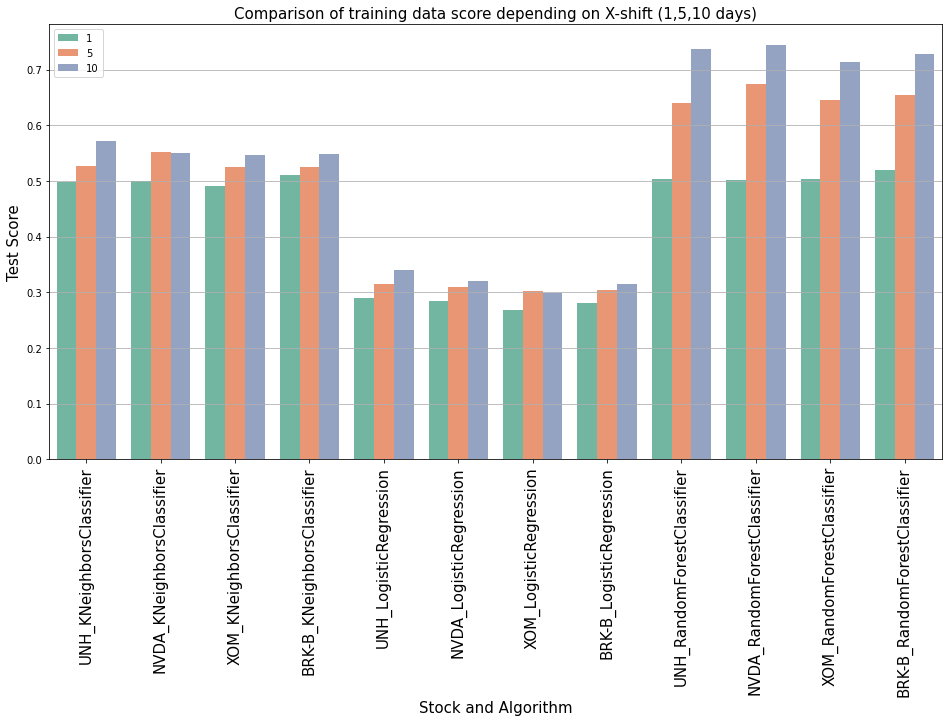

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plot_df=grid_results.copy()
plot_df.sort_values(by=['X_shift','Classifier'],inplace=True)
plot_df['Name']=grid_results['Ticker'] + '_' + grid_results['Classifier'] #+ '_' + grid_results['X_shift'].astype('str')
plot_df['Train Score']=grid_results['Train Score']
plot_df['Test Score']=grid_results['Test Score']
plot_df['X_shift']=grid_results['X_shift']
plt.figure(figsize=(16,8))
plt.grid(axis='both',fillstyle='bottom')
sns.barplot(x=plot_df['Name'],y=plot_df['Test Score'],hue=plot_df['X_shift'],palette=sns.color_palette('Set2'))
plt.legend()
plt.title('Comparison of training data score depending on X-shift (1,5,10 days)',size=15)
plt.xlabel('Stock and Algorithm',size=15)
plt.ylabel('Test Score',size=15)
plt.xticks(rotation=90,size=15)

# Enhancing hyperparameters RFC (np scaling/with StratKFold) [Tickers: UNH, NVDA, XOM, BRK-B]

In [ ]:
df=load_csv_df('new_data/Yfinance/Yfinance_all_stocks_20230105')
df=df.rename({'Unnamed: 0':'Index'},axis=1)
df['Date']=pd.to_datetime(df['Date'])

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# This Script takes some time!
# Dependencies
from datetime import date, datetime

# Results
results=pd.DataFrame()

# Timestamp
timestamp=datetime.now().strftime('%Y%m%d_%H%M%S')

#Tickers
test_tickers = {'UNH':'UnitedHealth','NVDA':'NVIDIA','XOM':'Exxon Mobile','BRK-B':'Berkshire Hathaway'}


# Algo Setup
# Classifier
rfc=RandomForestClassifier(random_state=1)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,random_state=1)


# Parameters RandomForestClassifier
# Parameters as per https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
n_estimators=[100,500,1000]
max_features=[20,30,40]
parameters_rfc=dict(n_estimators=n_estimators,max_features=max_features)

# List of used classifiers
clf_dict={'RandomForestClassifier':rfc}

# Setup grid results DF
grid_results=pd.DataFrame(columns=['Ticker','Classifier','X_shift','Best_params','Train Score','Train STD','Test Score','Test STD','Runtime','Date'])

# DF Index = 0
index=0

# ticker count
tick_count=0

for ticktick in test_tickers.keys():
  print('New ticker:',ticktick)
  print('---------------------')
  # stock_feature_generator Object
  data=stock_feature_generator(threshold=0.1,ticker=ticktick)
  data.fit(df)
  new_data=data.transform()
  new_data.drop(['Ticker','Weekday_Str','Date'],axis=1,inplace=True)

  # Classifier count
  clf_count=0
  for j,k in zip(clf_dict.keys(),clf_dict.values()):
    sft_count=0
    model=k
    if (j=='RandomForestClassifier'):
      parameters=parameters_rfc
    elif (j=='LogisticRegression'):
      parameters=parameters_lrc
    elif (j=='KNeighborsClassifier'):
      parameters=parameters_knc
    elif (j=='SVC'):
      parameters=parameters_svc

    # GridSearchCV
    grid=GridSearchCV(estimator=model,param_grid=parameters,n_jobs=-1,cv=cv,scoring='accuracy',error_score=0,verbose=0,return_train_score=True)

    # Automated Algorithm runner (Shifter)
    for i in [10]:
      # Get start time
      t_start=timeit.default_timer()

      # Data prep
      # Shift X
      new_data['target']=new_data['X_'+str(i)].shift(-i)

      df2=new_data.dropna()

      # Set up X and y
      y=df2['target']
      X=df2.drop(['target','X_1','X_5','X_10'],axis=1)

      # Standard Scaler
      norm = StandardScaler()
      X_scaled=norm.fit_transform(X)
      y_transformed=[1 if x > 1 else 0 for x in y]
      X_train,X_test,y_train,y_test=train_test_split(X_scaled,y_transformed,test_size=0.2,random_state=1)
      
      # Fit Algorithm
      #print('\n\n',grid.estimator,'Fitting for',i,'days of re-shift of X')
      print('Estimator:',grid.estimator)
      print('X Shift:',i)
      print('Start time:',datetime.now().strftime('%d.%m.%Y %H:%M:%S'))
      result=grid.fit(X_train,y_train)

      # Get finish time
      t_stop=timeit.default_timer()

      # Results
      print('Best params:',str(grid.best_params_))
      print('Train Score:',grid.cv_results_['mean_train_score'].mean(),'\nSTD:',grid.cv_results_['std_train_score'].mean())
      print('Test Score (CV): ',grid.cv_results_['mean_test_score'].mean(),'\nSTD',grid.cv_results_['std_test_score'].mean())
      # Score with y_test
      print('Test Score (y_test):',grid.score(X_test,y_test))
      runtime=round(t_stop-t_start,2)
      print(f'Runtime: {runtime}s')
      print('\n')

      # Populate grid_results DF
      new_row={'Ticker':ticktick,
               'Classifier':j,
               'X_shift':i,
               'Best_params':str(grid.best_params_),
               'Train Score':grid.cv_results_['mean_train_score'].mean(),
               'Test Score': grid.cv_results_['mean_test_score'].mean(),
               'Train STD':grid.cv_results_['std_train_score'].mean(),
               'Test STD':grid.cv_results_['std_test_score'].mean(),
               'Date':timestamp,
               'Runtime':runtime}
      grid_results=grid_results.append(new_row,ignore_index=True)

      # Model dump
      dump(grid,r'/drive/My Drive/OPA/Datasets/new_data/Joblibs/2nd_hyper_test' + timestamp + '_' + ticktick + '_' + j + '_' + str(i) + '.joblib')
      sft_count+=1
    clf_count+=1
  tick_count+=1

# Save Grid Results
save_csv_df(grid_results,'new_data/grid_searches/grid_results_2nd_hyper_test_' + timestamp)

In [ ]:
# Load Grid Results
name='grid_results_2nd_hyper_test_20230106_123257'
drive.mount('/drive')
grid_results=pd.read_csv('/drive/My Drive/OPA/Datasets/new_data/grid_searches/'+ name +'.csv',index_col='Unnamed: 0')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


# RFC with best hyperparameters (no scaling)

In [ ]:
df=load_csv_df('new_data/Yfinance/Yfinance_all_stocks_20230105')
df=df.rename({'Unnamed: 0':'Index'},axis=1)
df['Date']=pd.to_datetime(df['Date'])

In [ ]:
# This Script takes some time!
# Dependencies
from datetime import date, datetime

# Results
results=pd.DataFrame()

# Timestamp
timestamp=datetime.now().strftime('%Y%m%d_%H%M%S')

#Tickers
test_tickers = {'AAPL':'Apple','MSFT':'Microsoft',
                'AMZN':'Amazon','BRK-B':'Berkshire Hathaway',
                'UNH':'UnitedHealth','JNJ':'Johnson & Johnson',
                'V':'VISA','TSM':'TSMC','NVDA':'NVIDIA','XOM':'Exxon Mobile',
                'WMT':'Walmart','PG':'Procter & Gamble','JPM':'JPMorgan Chase',
                'MA':'Mastercard','HD':'Home Depot'}

# Algo Setup
# Classifier
n_estimators=1000
max_features=20
rfc=RandomForestClassifier(random_state=1,n_estimators=n_estimators,max_features=max_features)

# Setup grid results DF
grid_results=pd.DataFrame(columns=['Ticker','Classifier','X_shift','Train Score','Test Score','Runtime','Date'])

for ticktick in test_tickers.keys():
  # Get start time
  t_start=timeit.default_timer()

  print('New ticker:',ticktick)
  print('---------------------')
  # stock_feature_generator Object
  data=stock_feature_generator(threshold=0.1,ticker=ticktick)
  data.fit(df)
  new_data=data.transform()
  new_data.drop(['Ticker','Weekday_Str','Date'],axis=1,inplace=True)
  new_data['target']=new_data['X_10'].shift(-10)
  df2=new_data.dropna()

  # Set up X and y
  y=df2['target']
  X=df2.drop(['target','X_1','X_5','X_10'],axis=1)

  y_transformed=[1 if x > 1 else 0 for x in y]
  X_train,X_test,y_train,y_test=train_test_split(X,y_transformed,test_size=0.2,random_state=1)
      
  # Fit Algorithm
  #print('\n\n',grid.estimator,'Fitting for',i,'days of re-shift of X')
  print('Estimator:',rfc)
  print('X Shift: 10')
  print('Start time:',datetime.now().strftime('%d.%m.%Y %H:%M:%S'))
  result=rfc.fit(X_train,y_train)

  # Get finish time
  t_stop=timeit.default_timer()

  # Results
  result_train=round(result.score(X_train,y_train),4)
  print('Train Score:',result_train)
  # Score with y_test
  result_test=round(result.score(X_test,y_test),4)
  print('Test Score:',result_test)
  runtime=round(t_stop-t_start,2)
  print(f'Runtime: {runtime}s')
  print('\n')

  # Populate grid_results DF
  new_row={'Ticker':ticktick,
            'Classifier':'RandomForestClassifier',
            'X_shift':'10',
            'Train Score':result_train,
            'Test Score':result_test,
            'Date':timestamp,
            'Runtime':runtime}
  grid_results=grid_results.append(new_row,ignore_index=True)

  # Model dump
  dump(result,r'/drive/My Drive/OPA/Datasets/new_data/Joblibs/final_models_' + timestamp + '_' + ticktick + '_' + j + '_' + str(i) + '.joblib')

# Save Grid Results
save_csv_df(grid_results,'new_data/grid_searches/grid_results_final_models_' + timestamp)

In [ ]:
# Load Grid Results
name='grid_results_final_models_20230106_140238'
drive.mount('/drive')
grid_results=pd.read_csv('/drive/My Drive/OPA/Datasets/new_data/grid_searches/'+ name +'.csv',index_col='Unnamed: 0')

In [ ]:
grid_results.set_index('Ticker',inplace=True)
display(grid_results.sort_values(by='Test Score',ascending=False))

,Classifier,X_shift,Train Score,Test Score,Runtime,Date
Ticker,,,,,,
BRK-B,RandomForestClassifier,10,1.0,0.8180,29.36,20230106_140238
JNJ,RandomForestClassifier,10,1.0,0.8047,29.53,20230106_140238
WMT,RandomForestClassifier,10,1.0,0.8047,30.24,20230106_140238
AAPL,RandomForestClassifier,10,1.0,0.8013,28.61,20230106_140238
XOM,RandomForestClassifier,10,1.0,0.7997,28.13,20230106_140238
TSM,RandomForestClassifier,10,1.0,0.7947,35.89,20230106_140238
JPM,RandomForestClassifier,10,1.0,0.7930,28.91,20230106_140238
HD,RandomForestClassifier,10,1.0,0.7913,28.89,20230106_140238
AMZN,RandomForestClassifier,10,1.0,0.7896,28.52,20230106_140238


(0.7, 0.85)

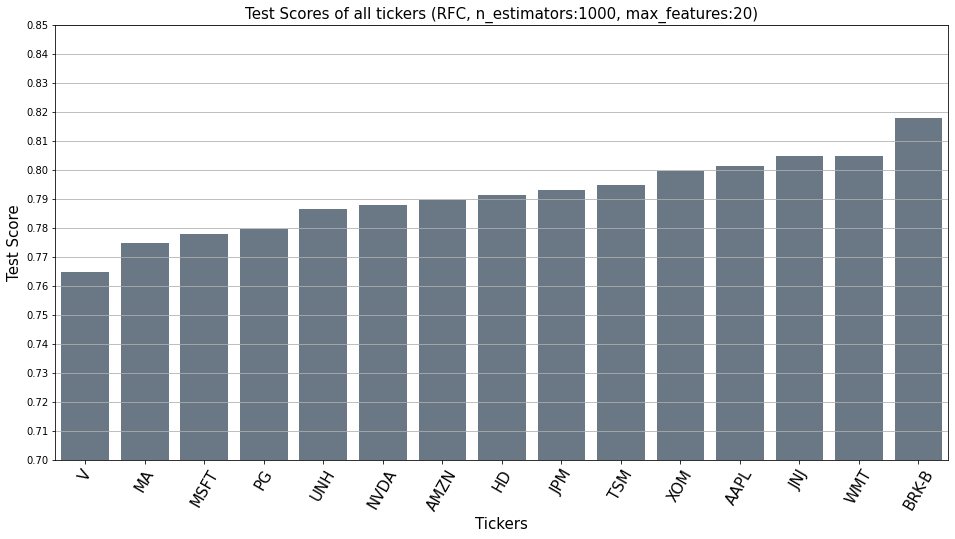

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plot_df=grid_results.sort_values(by='Test Score').copy()
plot_df['Train Score']=grid_results['Train Score']
plot_df['Test Score']=grid_results['Test Score']
plot_df=plot_df.sort_values(by='Train Score',ascending=1)
plt.figure(figsize=(16,8))
plt.grid(axis='both',fillstyle='bottom')

sns.barplot(x=plot_df['Ticker'],y=plot_df['Test Score'],dodge=False,color='#667788')
plt.xlabel('Tickers',size=15)
plt.ylabel('Test Score',size=15)
plt.xticks(rotation=60,size=15)
plt.yticks(np.arange(0.7, 1, step=0.01))
plt.title('Test Scores of all tickers (RFC, n_estimators:1000, max_features:20)',size=15)
plt.ylim(0.7,0.85)

# *Portfolio Management

In [ ]:
df=load_csv_df('new_data/Yfinance/Yfinance_all_stocks_20230105')
df=df.rename({'Unnamed: 0':'Index'},axis=1)
df['Date']=pd.to_datetime(df['Date'])

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
class Portfolio(TransformerMixin,BaseEstimator):
  def __init__(self,data,tickers,start_invest=10000,sum_per_invest=500,buy_threshold=0.5,sell_threshold=0.3,buy_signal=3,sell_signal=1,silent_mode=False,self_adjust=False):
    ''''
    Initinalization of parsed input data
    ''''
    # Data with the following Layout:
    # Ticker	Date	Open	High	Low	Close	Volume	Dividends	Stock Splits
    self.data=data
    # Ticker(s) list
    self.tickers=tickers
    # Invest money
    self.start_invest=start_invest
    # Invest sum per invest
    self.sum_per_invest=sum_per_invest

    # Buy threshold where buy signal is generated
    self.buy_threshold=buy_threshold
    # Sell threshold where full qty of given stock is sold
    self.sell_threshold=sell_threshold

    # Buy signal. Counter of cummulative buy signals that need to be reached before buying
    self.buy_signal=buy_signal
    # Sell signal. Counter of cummulative sell signals that need to be reached before selling
    self.sell_signal=sell_signal

    # Composition limits. It allows no less than 30% composition for any stock
    length_tick=len(tickers)
    if len(tickers) == 1:
      self.comp_limit=1
    elif len(tickers) == 2:
      self.comp_limit=0.6
    elif len(tickers) == 3:
      self.comp_limit=0.4
    elif len(tickers) >= 4:
      self.comp_limit=0.3

    # Set up Logfile DF
    self.logfile=pd.DataFrame({'Date':pd.Series(dtype=str),
                               'Stock':pd.Series(dtype=str),
                               'Buy_Signal':pd.Series(dtype=int),
                               'Sell_Signal':pd.Series(dtype=int),
                               'Action':pd.Series(dtype=str),
                               'inv_qty_cum':pd.Series(dtype=int),
                               'inv_cash_cum':pd.Series(dtype=int),
                               'mean_stock_val':pd.Series(dtype=int),
                               'Close':pd.Series(dtype=int),
                               'Port_total':pd.Series(dtype=int),
                               'sum_per_inv':pd.Series(dtype=float),
                               'Book_value':pd.Series(dtype=int)})
    self.logfile['Date']=pd.to_datetime(self.logfile['Date'])

    # Silent Mode. Toggles additional messages when manager is running.
    self.silent_mode=silent_mode

    # Get Start Time
    self.t_start=timeit.default_timer()

    # Self adjustment of sum_per_invest
    self.self_adjust=self_adjust

    # Determine ratio of sum_invest / sum_per_invest to keep ratio
    self.invest_ratio=round(self.start_invest / self.sum_per_invest,2)

    # Hysteresis of ratio self adjustment
    self.ratio_hysteresis=0.05
    print(f'Ratio: {self.invest_ratio}')

  def data_prepare(self):
    ''''
    Preparation of stock data
    ''''
    timestamp=datetime.now().strftime('%d.%m.%Y %H:%M:%S')
    print(timestamp," - Starting Prepare")
    # Dictionary that contains all the prepared data
    self.input_prep_dict=dict()
    self.data_unscaled=pd.DataFrame()

    # Transforming input data to fitted and scaled data
    for stock in self.tickers:
      sfg=stock_feature_generator(threshold=0.1,ticker=stock)
      sfg.fit(self.data[self.data['Ticker']==stock])
      self.data_input=sfg.transform()

      self.data_unscaled=pd.concat([self.data_unscaled,self.data_input],axis=0)

      self.data_input.set_index('Date',inplace=True)
      self.data_input.drop(['Ticker','Weekday_Str','X_1','X_5','X_10'],axis=1,inplace=True)
      
      norm=StandardScaler()
      self.data_input=norm.fit_transform(self.data_input)
      
      self.input_prep_dict[stock]=self.data_input
    print("Data Preparation finished!")

  def load_model(self,key):
    ''''
    Load Model from subfolder
    --------
    Parameters:
    key: Stock name of file to load   
    ''''
    path='/drive/My Drive/OPA/Joblibs/Saved/2022_11_29_All_Tickers_RandomForest/dump_20221128_214139_' + key + '_RandomForestClassifier_10.joblib'
    model=load(path)  
    print('Loading Estimator:',key)
    return model

  def fill_ticker_dict(self):
    ''''
    Load the models into the ticker dictionary
    ''''
    timestamp=datetime.now().strftime('%d.%m.%Y %H:%M:%S')
    print('--------------------------------------------------------------------')
    print(timestamp," - Loading pre-fitted estimators")
    self.ticker_models={}
    for key in self.tickers:
      self.ticker_models[key]=self.load_model(key)
    print("Loaded all estimators!")

  def predict(self):
    ''''
    Prediction of the target values
    0 -> Falling stock in 10 days
    1 -> Rising stock in 10 days
    ''''
    self.data_prepare()
    self.fill_ticker_dict()
    timestamp=datetime.now().strftime('%d.%m.%Y %H:%M:%S')
    print('--------------------------------------------------------------------')
    print(timestamp," - Starting Prediction")
    t_start=timeit.default_timer()
    self.prediction=pd.DataFrame()

    # DF that contains the results of the predictions
    for stock in self.tickers:
      self.model=self.ticker_models[stock]
      t_start_iter=timeit.default_timer()
      print('Predicting Stock:',stock)

      y_pred=self.model.predict(self.input_prep_dict[stock])
      y_pred_proba=self.model.predict_proba(self.input_prep_dict[stock])

      pred_for_stock=pd.DataFrame({'Stock':stock,'pred':y_pred,'pred_proba_0':y_pred_proba[:,0],'pred_proba_1':y_pred_proba[:,1]})
      pred_1=pred_for_stock[pred_for_stock['pred']==1]['pred'].count()
      pred_0=pred_for_stock[pred_for_stock['pred']==0]['pred'].count()
      print("Prediction finished! 1:",pred_1,', 0:',pred_0)
      self.prediction=pd.concat([self.prediction,pred_for_stock])
      
      runtime_iter=round(timeit.default_timer()-t_start_iter,2)
    self.prediction=pd.concat([self.prediction.reset_index()[['Stock','pred','pred_proba_0','pred_proba_1']],self.data_unscaled.reset_index()[['Date','Close']]],axis=1)
    self.prediction['Date']=self.prediction['Date'].astype(str)
    self.prediction.set_index('Date',inplace=True)

    t_stop=timeit.default_timer()
    runtime=round(t_stop-t_start,2)
    print(f'Runtime: {runtime}s')

  def load_predictions(self,name):
    ''''
    Load pre-calculated predictions from file
    ''''
    prediction=pd.DataFrame()
    self.prediction=pd.read_csv('/drive/My Drive/OPA/Datasets/'+ name +'.csv',index_col='Date')
    # Limiting to only selected tickers
    for stock in self.tickers:
      prediction=prediction.append(self.prediction[self.prediction['Stock']==stock])
    self.prediction=prediction

  def save_predictions(self):
    ''''
    Saving of predictions for later use
    ''''
    timestamp=datetime.now().strftime('%Y%m%d_%H%M%S')
    drive.mount('/drive')
    tickers=' '.join(self.tickers)
    path='/drive/My Drive/OPA/Datasets/predictions_'+ tickers + '_' + timestamp +'.csv'
    self.prediction.to_csv(path)
    print(timestamp," - Saved to: ",path)

  def build_portfolio_df(self):
    ''''
    Initial building of the portfolio DF
    ''''
    ticker_dict=dict({'Stock':['Cash'],'inv_qty':[1],'mean_stock_val':[0],'inv_cash':[self.start_invest],'composition':[0],'buy_signal':[0],'sell_signal':[0],'total_buy':[0],'total_sell':[0],'exec_buy':[0],'exec_sell':[0]})
    self.portfolio=pd.DataFrame(ticker_dict)
    for i in self.tickers:
      ticker_dict=dict({'Stock':[i],'inv_qty':[0],'mean_stock_val':[0],'inv_cash':[0],'composition':[0],'buy_signal':[0],'sell_signal':[0],'total_buy':[0],'total_sell':[0],'exec_buy':[0],'exec_sell':[0]})
      self.portfolio=pd.concat([self.portfolio,pd.DataFrame(ticker_dict)],axis=0)
    self.portfolio.set_index('Stock',inplace=True)

  def calc_compositions(self):
    ''''
    Calculation of portfolio composition
    ''''
    for stock in self.tickers:
      self.portfolio.loc[stock,'composition'] = self.portfolio.loc[stock,'inv_cash'] / self.portfolio['inv_cash'].sum()
    self.portfolio.loc['Cash','composition'] = self.portfolio.loc['Cash','inv_cash'] / self.portfolio['inv_cash'].sum()

  def write_logfile(self,date,stock,buy_signal,sell_signal,action,qty,cash,mean_stock_val,close,port_total,book_value,sum_per_inv):
    ''''
    Writes a logfile entry for each date parsed
    ''''
    new_row={'Date':date,
             'Stock':stock,
             'Buy_Signal':buy_signal,
             'Sell_Signal':sell_signal,
             'Action':action,
             'inv_qty_cum':qty,
             'inv_cash_cum':cash,
             'mean_stock_val':mean_stock_val,
             'Close':close,
             'Port_total':port_total,
             'sum_per_inv':sum_per_inv,
             'Book_value':book_value}
    self.logfile=self.logfile.append(new_row,ignore_index=True)

  def get_runtime(self):
    ''''
    Calculating the run time
    ''''
    t_stop=timeit.default_timer()
    runtime=round(t_stop-self.t_start,2)
    return runtime

  def invest(self,start_date):
    ''''
    Investment function
    -------------
    Parameters:
    start_date: Start date of investment
    ''''
    timestamp=datetime.now().strftime('%d.%m.%Y %H:%M:%S')
    print('--------------------------------------------------------------------')
    print(timestamp," - Starting Invest (start date:",start_date,")")
    buy_counter=0

    t_start=timeit.default_timer()

    # Reformat start_date so it's comparable with prediction.index
    start_date_dt=dt.datetime.strptime(start_date,'%Y-%m-%d')

    # Build Portfolio DF
    self.build_portfolio_df()

    # Iterate all unique dates
    for date in self.prediction.reset_index()['Date'].unique():

      # If date is later than passed start_date
      if dt.datetime.strptime(date,'%Y-%m-%d') >= start_date_dt:
        date_df=self.prediction[self.prediction.index==date].reset_index().set_index('Stock')

        # Go through predictions of all stocks
        # If stock is above threshold write buy signal for that stock
        for stock in self.tickers:

          # if pred_proba_1 of a stock is higher than the passed buy threshold
          if date_df.loc[stock,'pred_proba_1'] >= self.buy_threshold:
            # Set buy signal for that stock in portfolio
            self.portfolio.loc[stock,'buy_signal'] += 1
            self.portfolio.loc[stock,'total_buy'] += 1
          else:
            # Reset buy signal if pred_proba_1 < self.buy_threshold
            # This allows only consecutive buy signals to build up
            self.portfolio.loc[stock,'buy_signal'] = 0
          
          # if pred_proba_1 of a stock is lower than the passed sell threshold
          if date_df.loc[stock,'pred_proba_1'] <= self.sell_threshold:
            # Set sell signal for that stock in portfolio
            self.portfolio.loc[stock,'sell_signal'] += 1
            self.portfolio.loc[stock,'total_sell'] += 1
          else:
            # Reset sell signal if pred_proba_1 < self.sell_treshold
            # This allows only consecutive sell signals to build up
            self.portfolio.loc[stock,'sell_signal'] += 0

        # Buy or sell if respective amount of signals is reached
        # Stock with highest proba for that day is sold first
        for stock in date_df.sort_values(by='pred_proba_1',ascending=False).index:
          logged=0
          # Signal for S10 if in this cycle stock has been sold
          bought=0

          # Adjust sum_per_invest
          if self.self_adjust:
            new_spi=self.portfolio['inv_cash'].sum()/self.invest_ratio
            if new_spi > (self.sum_per_invest * (1+self.ratio_hysteresis)):
              print(date,"Raising sum_per_invest to:",round(new_spi,2))
              self.sum_per_invest=new_spi
            elif new_spi < (self.sum_per_invest * (1-self.ratio_hysteresis)):
              print(date,"Lowering sum_per_invest to:",round(new_spi,2))
              self.sum_per_invest=new_spi

          if self.portfolio.loc[stock,'buy_signal'] >= self.buy_signal:
            if not self.silent_mode:
              print(stock,'Buy Signal?:',self.portfolio.loc[stock,'buy_signal'])
              print(date)

            # get old qty and mean stock value
            old_qty=self.portfolio.loc[stock,'inv_qty']
            old_mean_stock_val=self.portfolio.loc[stock,'mean_stock_val']

            # Determine new buy qty
            # inv_sum cannot allow stock to become more than X% of the whole portfolio
            # inv_sum must be smaller than cash
            inv_sum=self.sum_per_invest
            qty=(inv_sum // date_df.loc[stock,'Close'])

            # If planned invest sum is larger than cash reduce qty
            if ((qty * date_df.loc[stock,'Close']) >= self.portfolio.loc['Cash','inv_cash']):
              qty=self.portfolio.loc['Cash','inv_cash'] // date_df.loc[stock,'Close']
              if not self.silent_mode:
                print(">>",stock,"\n",date," | Full qty not possible through cash limit. Buying",qty,"stock!")

            # calculate new stock composition to determine if purchase is allowed or
            # if new composition exceeds limit
            new_comp=(self.portfolio.loc[stock,'inv_cash']+(qty * date_df.loc[stock,'Close'])) / self.portfolio['inv_cash'].sum()

            # If the planned invest sum is smaller than cash money
            if ((qty > 0) and ((qty * date_df.loc[stock,'Close']) <= self.portfolio.loc['Cash','inv_cash'])):
              # stock composition cannot be higher than comp_limit or purchase is neglected
              if (new_comp <= self.comp_limit):
                if not self.silent_mode:
                  print(">> BUY",stock,"\n",date," | Qty :",qty,"| Close: ",round(date_df.loc[stock,'Close'],2),"| Inv Sum: ",round(qty * date_df.loc[stock,'Close'],2))
                  print('--------------------------------------------------------------------')
                mean_stock_val=((old_qty * old_mean_stock_val)+(qty * date_df.loc[stock,'Close']))/(old_qty+qty)
                
                # Rewrite the portfolio
                self.portfolio.loc[stock,'inv_qty']=old_qty + qty
                self.portfolio.loc[stock,'mean_stock_val']=mean_stock_val
                self.portfolio.loc[stock,'inv_cash']=self.portfolio.loc[stock,'inv_qty'] * self.portfolio.loc[stock,'mean_stock_val']
                self.portfolio.loc['Cash','inv_cash'] -= qty * date_df.loc[stock,'Close']
                self.portfolio.loc[stock,'composition'] = self.portfolio.loc[stock,'inv_cash'] / self.portfolio['inv_cash'].sum()
                self.portfolio.loc['Cash','composition'] = self.portfolio.loc['Cash','inv_cash'] / self.portfolio['inv_cash'].sum()
                self.portfolio.loc[stock,'exec_buy'] += 1
                self.calc_compositions()
                self.write_logfile(date=date,
                                   stock=stock,
                                   buy_signal=self.portfolio.loc[stock,'buy_signal'],
                                   sell_signal=self.portfolio.loc[stock,'sell_signal'],
                                   action='B',
                                   qty=self.portfolio.loc[stock,'inv_qty'],
                                   cash=self.portfolio.loc[stock,'inv_cash'],
                                   mean_stock_val=self.portfolio.loc[stock,'mean_stock_val'],
                                   close=date_df.loc[stock,'Close'],
                                   port_total=self.portfolio['inv_cash'].sum(),
                                   sum_per_inv=self.sum_per_invest,
                                   book_value=(self.portfolio.loc[stock,'inv_qty'] * date_df.loc[stock,'Close'])
                                   )
                bought_stock=1
                logged=1

              else:
                if not self.silent_mode:
                  print(">> BUY",stock,"\n",date," | Composition limit triggered! Purchase abandonded!")
                  print('--------------------------------------------------------------------')
                #self.portfolio.loc[stock,'buy_signal']=0

          # Sell stocks per Sell Signal
          if ((self.portfolio.loc[stock,'sell_signal'] >= self.sell_signal) and (self.portfolio.loc[stock,'inv_qty'] > 0)):
            if not self.silent_mode:
              print(">> SELL (triggered)",stock,"\n",date," | Qty :",self.portfolio.loc[stock,'inv_qty'],"| MSP:",round(self.portfolio.loc[stock,'mean_stock_val'],2),"| Close: ",round(date_df.loc[stock,'Close'],2),"| Sell Sum: ",round(self.portfolio.loc[stock,'inv_qty'] * date_df.loc[stock,'Close'],2))
              revenue=self.portfolio.loc[stock,'inv_qty'] * (date_df.loc[stock,'Close'] - self.portfolio.loc[stock,'mean_stock_val'])
              print("Revenue:",round(revenue,2))
              print('--------------------------------------------------------------------')

            # Sell that stock and add earnings to cash
            self.portfolio.loc['Cash','inv_cash'] += self.portfolio.loc[stock,'inv_qty'] * date_df.loc[stock,'Close'] 
            self.portfolio.loc[stock,'inv_cash']=0
            self.portfolio.loc[stock,'inv_qty']=0
            self.portfolio.loc[stock,'mean_stock_val']=0
            self.portfolio.loc['Cash','composition'] = self.portfolio.loc['Cash','inv_cash'] / self.portfolio['inv_cash'].sum()
            self.portfolio.loc[stock,'exec_sell'] += 1
            self.calc_compositions()
            self.write_logfile(date=date,
                    stock=stock,
                    buy_signal=self.portfolio.loc[stock,'buy_signal'],
                    sell_signal=self.portfolio.loc[stock,'sell_signal'],
                    action='S',
                    qty=self.portfolio.loc[stock,'inv_qty'],
                    cash=self.portfolio.loc[stock,'inv_cash'],
                    mean_stock_val=self.portfolio.loc[stock,'mean_stock_val'],
                    close=date_df.loc[stock,'Close'],
                    port_total=self.portfolio['inv_cash'].sum(),
                    sum_per_inv=self.sum_per_invest,
                    book_value=(self.portfolio.loc[stock,'inv_qty'] * date_df.loc[stock,'Close'])
                    )
            logged=1
            # Reset of sell signal for that stock
            self.portfolio.loc[stock,'sell_signal']=0

          # Reset Sell Signal if qty = 0
          elif (self.portfolio.loc[stock,'sell_signal'] >= self.sell_signal):
            self.portfolio.loc[stock,'sell_signal']=0

          # Sell if 10% revenue is reached
          elif ((self.portfolio.loc[stock,'mean_stock_val'] > (date_df.loc[stock,'Close']*1.1)) and bought != 0):
            if not self.silent_mode:
              print(">> SELL (10%)",stock,"\n",date," | Qty :",self.portfolio.loc[stock,'inv_qty'],"| MSP:",round(self.portfolio.loc[stock,'mean_stock_val'],2),"| Close: ",round(date_df.loc[stock,'Close'],2),"| Sell Sum: ",round(self.portfolio.loc[stock,'inv_qty'] * date_df.loc[stock,'Close'],2))
              revenue=self.portfolio.loc[stock,'inv_qty'] * (date_df.loc[stock,'Close'] - self.portfolio.loc[stock,'mean_stock_val'])
              print("Revenue:",round(revenue,2))
              print('--------------------------------------------------------------------')
            # Sell that stock and add earnings to cash
            self.portfolio.loc['Cash','inv_cash'] += self.portfolio.loc[stock,'inv_qty'] * date_df.loc[stock,'Close'] 
            self.portfolio.loc[stock,'inv_cash']=0
            self.portfolio.loc[stock,'inv_qty']=0
            self.portfolio.loc[stock,'mean_stock_val']=0
            self.portfolio.loc['Cash','composition'] = self.portfolio.loc['Cash','inv_cash'] / self.portfolio['inv_cash'].sum()
            self.portfolio.loc[stock,'exec_sell'] += 1
            self.calc_compositions()
            self.write_logfile(date=date,
                    stock=stock,
                    buy_signal=self.portfolio.loc[stock,'buy_signal'],
                    sell_signal=self.portfolio.loc[stock,'sell_signal'],
                    action='S10',
                    qty=self.portfolio.loc[stock,'inv_qty'],
                    cash=self.portfolio.loc[stock,'inv_cash'],
                    mean_stock_val=self.portfolio.loc[stock,'mean_stock_val'],
                    close=date_df.loc[stock,'Close'],
                    port_total=self.portfolio['inv_cash'].sum(),
                    sum_per_inv=self.sum_per_invest,
                    book_value=(self.portfolio.loc[stock,'inv_qty'] * date_df.loc[stock,'Close'])
                    )
            logged=1

          # If there has not been a logfile entry yet
          if logged==0:
            self.write_logfile(date=date,
                             stock=stock,
                             buy_signal=self.portfolio.loc[stock,'buy_signal'],
                             sell_signal=self.portfolio.loc[stock,'sell_signal'],
                             action='-',
                             qty=self.portfolio.loc[stock,'inv_qty'],
                             cash=self.portfolio.loc[stock,'inv_cash'],
                             mean_stock_val=self.portfolio.loc[stock,'mean_stock_val'],
                             close=date_df.loc[stock,'Close'],
                             port_total=self.portfolio['inv_cash'].sum(),
                             sum_per_inv=self.sum_per_invest,
                             book_value=(self.portfolio.loc[stock,'inv_qty'] * date_df.loc[stock,'Close'])
                             )

    if not self.silent_mode:
      display(self.portfolio)

    t_stop=timeit.default_timer()
    self.runtime=round(t_stop-t_start,2)
    print('Invest Finished!')

  def print_params(self):
    ''''
    Prints an overview of all parameters of the portfolio manager
    ''''
    print("BuyT:",self.buy_threshold,"| BuyS:",self.buy_signal,"| SellT:",self.sell_threshold,"| SellS:",self.sell_signal,"| StInv:",self.start_invest,"| SpI:",round(self.sum_per_invest,2),"| Tickers:",self.tickers)

  def score(self):
    ''''
    Calculates the portfolio score
    ''''
    cash=self.portfolio.loc['Cash','inv_cash']
    summe=0
    for tick in self.tickers:
      book_value=self.portfolio.loc[tick,'inv_qty'] * self.logfile[port.logfile['Stock']==tick].iloc[-1,8]
      summe+=book_value
    return_val=(summe+cash) / self.start_invest
    return return_val

  def report(self):
    ''''
    Displays a report
    ''''
    book_val=round((self.score()*self.start_invest),2)
    print(f"Score: {round(self.score(),2)} | Book value: {book_val} | Runtime: {self.runtime}s")
    total_runtime=self.get_runtime()
    print(f'Total runtime: {total_runtime}s')
    print('--------------------------------------------------------------------------------------------------------------')
    if not self.silent_mode:
      print(self.portfolio)
      print('--------------------------------------------------------------------------------------------------------------')

  def graphical_report(self,length=10):
    '''
    Displays a graphical report
    ''''
    self.line_plot(length)
    self.stock_plot(length)
    self.stack_plot(length)

  def line_plot(self,length=10):
    ''''
    Line plot containing 'Cash' development as well as total portfolio worth
    and all stocks, including buy and sell signals
    ----------
    Parameters:
    length: Distance of xticks
    ''''
    plt.figure(figsize=(16,10))

    color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

    # Stocks
    for i,stock in zip(range(len(self.tickers)),self.tickers):
      x=self.logfile[self.logfile['Stock']==stock]['Date']
      y=self.logfile[self.logfile['Stock']==stock]['inv_cash_cum']
      y2=self.logfile[self.logfile['Stock']==stock]['Book_value']
      label='Money Invested in ' + stock
      label2='Book Value of ' + stock
      plt.plot(x,y,label=label,color=color_list[i])
      plt.plot(x,y2,label=label2,ls='--',color=color_list[i])
      
      x_buy=self.logfile[(self.logfile['Stock']==stock) & (self.logfile['Buy_Signal'] >= self.buy_signal)]['Date']
      y_buy=self.logfile[(self.logfile['Stock']==stock) & (self.logfile['Buy_Signal'] >= self.buy_signal)]['inv_cash_cum']
      plt.scatter(x_buy,y_buy,marker='^',color=color_list[i])
      
      x_sell=self.logfile[(self.logfile['Stock']==stock) & (self.logfile['Sell_Signal'] >= self.sell_signal)]['Date']
      y_sell=self.logfile[(self.logfile['Stock']==stock) & (self.logfile['Sell_Signal'] >= self.sell_signal)]['inv_cash_cum']
      plt.scatter(x_sell,y_sell,marker='v',color='black')

    # Cash
    label3="Cash"
    y3=self.logfile[self.logfile['Stock']==self.tickers[0]].reset_index()['Port_total']-self.logfile.groupby(['Date']).sum().reset_index()['inv_cash_cum']
    self.line_x_plot=x
    self.line_y3_plot=y3
    plt.plot(x,y3,label=label3)

    # Book Value
    label4="Book Value"
    y4=self.logfile.groupby(['Date']).sum().reset_index()['Book_value']+y3
    plt.plot(x,y4,label=label4,color='black')

    plt.axhline(port.start_invest,color='black',ls='--')

    x_ticker=pd.date_range(start='1/1/2010',end='12/31/2030',freq='M')
    plt.xlabel('Date')
    plt.ylabel('Portfolio [$]')
    plt.title('Portfolio development and buy/sell signals')
    plt.grid()
    plt.legend(loc='upper left')
    plt.xticks(x.astype('str')[::length],rotation=45);

  def stack_plot(self,length=10):
    ''''
    Stack Plot showing Portfolio composition
    -------------
    Parameters:
    length: Distance of xticks   
    ''''
    y=[]
    labels=[]
    colors=[]
    color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for i,ticker in zip(range(len(self.tickers)),self.tickers):
      #print(self.logfile[self.logfile['Stock']==ticker]['Date'].values)
      y.append(self.logfile[self.logfile['Stock']==ticker]['Book_value'].values)
      labels.append(ticker)
      colors.append(color_list[i])
    labels.append('Cash')
    plt.figure(figsize=(16,10))
    x=self.logfile[self.logfile['Stock']==self.tickers[0]]['Date'].values
    y.append(self.logfile[self.logfile['Stock']==self.tickers[0]].reset_index()['Port_total']-self.logfile.groupby(['Date']).sum().reset_index()['inv_cash_cum'])
    colors.append('darkorange')
    plt.stackplot(x,y,labels=labels,colors=colors)
    plt.grid()
    plt.xlabel('Date')
    plt.ylabel('Portfolio [$]')
    plt.title('Portfolio composition')
    plt.legend(loc='upper left')
    plt.xticks(x.astype('str')[::length],rotation=45);

  def stock_plot(self,length=10):
    ''''
    Line Plot showing closing prices of selected stocks
    -------------
    Parameters:
    length: Distance of xticks    
    ''''
    plt.figure(figsize=(16,10))
    color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for i,stock in zip(range(len(self.tickers)),self.tickers):
      x=self.logfile[self.logfile['Stock']==stock]['Date']
      y=self.logfile[self.logfile['Stock']==stock]['Close']
      label='Close price of ' + stock
      plt.plot(x,y,label=label,color=color_list[i])
    plt.xlabel('Date')
    plt.ylabel('Close price [$]')
    plt.title('Closing price of traded stocks')
    plt.grid()
    plt.legend(loc='upper left')
    plt.xticks(x.astype('str')[::length],rotation=45);

# First Portfolio run with [AAPL, MSFT, HD]

Getting YFinance Data. Date-in: 2022-01-01 Date-out: 2022-12-31
--------------------------------------------------------------------
HD
AAPL
MSFT
Finished getting YFinance Data!
Runtime: 0.82s
--------------------------------------------------------------------
Ratio: 10.0
11.01.2023 07:41:37  - Starting Prepare
stock_feature_generator(ticker='HD')
stock_feature_generator(ticker='AAPL')
stock_feature_generator(ticker='MSFT')
Data Preparation finished!
--------------------------------------------------------------------
11.01.2023 07:41:38  - Loading pre-fitted estimators
Loading Estimator: HD
Loading Estimator: AAPL
Loading Estimator: MSFT
Loaded all estimators!
--------------------------------------------------------------------
11.01.2023 07:41:40  - Starting Prediction
Predicting Stock: HD
Prediction finished! 1: 137 , 0: 95
Predicting Stock: AAPL
Prediction finished! 1: 137 , 0: 95
Predicting Stock: MSFT
Prediction finished! 1: 169 , 0: 63
Runtime: 1.0s
----------------------------

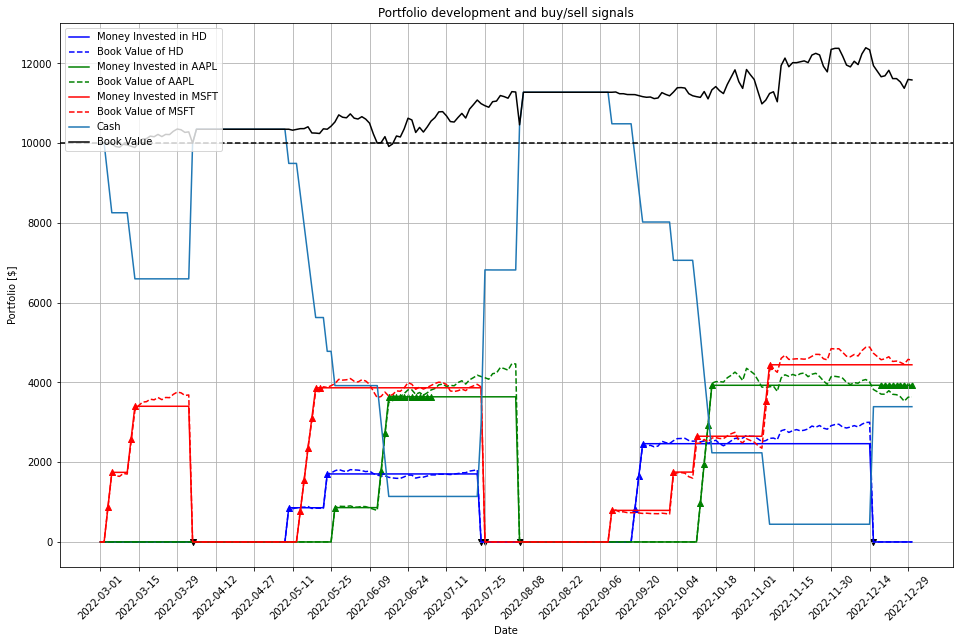

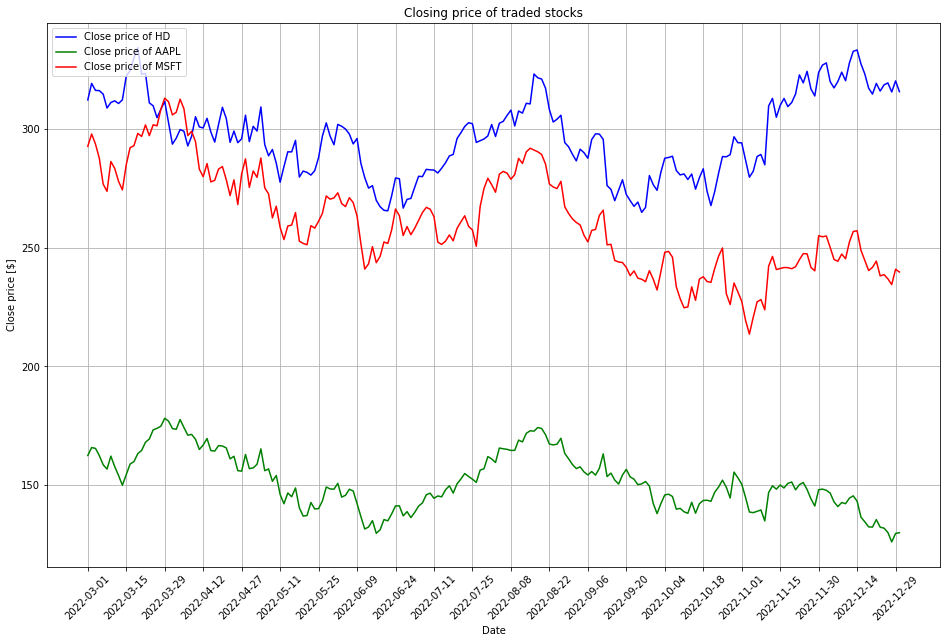

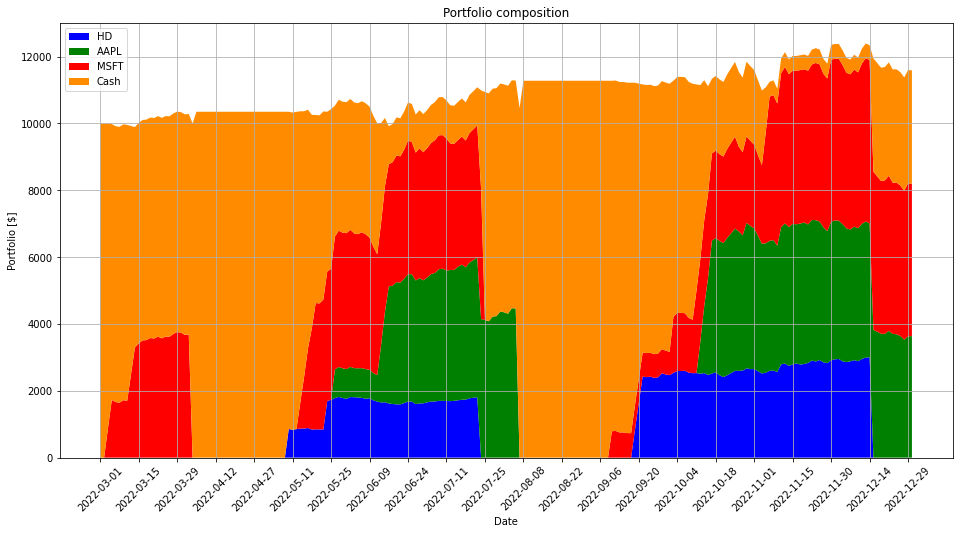

In [ ]:
# Create the object and run prepare and predict
port_tickers=['HD','AAPL','MSFT']
port=Portfolio(data=get_yfin_data('2022-12-31',port_tickers,delta=400,date_in='2022-01-01'),
               buy_threshold=0.65,
               sell_threshold=0.4,
               tickers=port_tickers,
               buy_signal=3,
               sell_signal=1,
               sum_per_invest=1000,
               start_invest=10000,
               silent_mode=True
               )

# Final predictions
#port.load_predictions('FINAL_predictions_all_stocks_20230107_094945') #Erzeugt mit prepare_old, fill_ticker_old, predict_old

port.predict()

port.invest('2022-03-01')

port.print_params()

port.report()

port.graphical_report()

In [ ]:
port.save_predictions()

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
20230107_094945  - Saved to:  /drive/My Drive/OPA/Datasets/predictions_AAPL MSFT AMZN BRK-B UNH JNJ V TSM NVDA XOM WMT PG JPM MA HD_20230107_094945.csv


In [ ]:
print(port.prediction) #pred_old

           Stock  pred  pred_proba_0  pred_proba_1       Close
Date                                                          
2022-01-31  AAPL     1         0.410         0.590  173.771454
2022-02-01  AAPL     1         0.466         0.534  173.602448
2022-02-02  AAPL     1         0.461         0.539  174.825348
2022-02-03  AAPL     1         0.407         0.593  171.902313
2022-02-04  AAPL     0         0.520         0.480  171.613632
...          ...   ...           ...           ...         ...
2022-12-23    HD     0         0.523         0.477  318.730011
2022-12-27    HD     1         0.499         0.501  319.549988
2022-12-28    HD     1         0.476         0.524  315.730011
2022-12-29    HD     1         0.497         0.503  320.410004
2022-12-30    HD     1         0.496         0.504  315.859985

[3480 rows x 5 columns]


# Generation and save of a prediction df of all tickers to speed up run time

In [ ]:
port_tickers=list(tickers.keys())
port=Portfolio(data=get_yfin_data('2022-12-31',port_tickers,delta=400,date_in='2022-01-01'),
               buy_threshold=0.60,
               sell_threshold=0.47,
               tickers=port_tickers,
               buy_signal=2,
               sell_signal=2,
               sum_per_invest=1000,
               start_invest=25000,
               silent_mode=True
               )

port.data_prepare()

port.fill_ticker_dict()

port.predict()

port.save_predictions()

# *Test of hyper-parameters

In [ ]:
buy_thresholds=[0.5,0.55,0.6,0.65]
sell_thresholds=[0.3,0.35,0.4,0.45]
buy_signals=[1,2,3,4]
sell_signals=[1,2,3,4]
sums_invest=[10000,15000,20000]
sums_per_invest=[500,1000,1500]

port_tickers=['HD','AAPL','MSFT']

timestamp=dt.datetime.now().strftime('%Y%m%d_%H%M%S')
print(timestamp)

Yfi_data=get_yfin_data('2022-12-31',port_tickers,delta=400,date_in='2022-01-01')

iterator=1
max_iter=len(buy_thresholds)*len(sell_thresholds)*len(buy_signals)*len(sell_signals)*len(sums_invest)*len(sums_per_invest)

parameters_test_df=pd.DataFrame({'buy_threshold':pd.Series(dtype=int),
                                 'sell_threshold':pd.Series(dtype=int),
                                 'buy_signal':pd.Series(dtype=int),
                                 'sell_signal':pd.Series(dtype=int),
                                 'sum_invest':pd.Series(dtype=int),
                                 'sum_per_invest':pd.Series(dtype=int),
                                 'score':pd.Series(dtype=int)
                                 })


for buy_threshold in buy_thresholds:
  for sell_threshold in sell_thresholds:
    for buy_signal in buy_signals:
      for sell_signal in sell_signals:
        for sum_invest in sums_invest:
          for sum_per_invest in sums_per_invest:
            print(iterator,"of",max_iter)
            iterator +=1
            port=Portfolio(data=Yfi_data,
                          buy_threshold=buy_threshold,
                          sell_threshold=sell_threshold,
                          tickers=port_tickers,
                          buy_signal=buy_signal,
                          sell_signal=sell_signal,
                          sum_per_invest=sum_per_invest,
                          start_invest=sum_invest,
                          silent_mode=True
                          )

            port.load_predictions('FINAL_predictions_all_stocks_20230107_094945')
            
            port.invest('2022-02-01')
            score=port.score()
            new_row=[{'buy_threshold':buy_threshold,
                                 'sell_threshold':sell_threshold,
                                 'buy_signal':buy_signal,
                                 'sell_signal':sell_signal,
                                 'sum_invest':sum_invest,
                                 'sum_per_invest':sum_per_invest,
                                 'score':score
                                 }]
            parameters_test_df=parameters_test_df.append(new_row,ignore_index=True)
            port.print_params()
            port.report()

drive.mount('/drive')

parameters_test_df.to_csv('/drive/My Drive/OPA/Datasets/portfolio_hyperparameters_consec_'+ timestamp + '.csv')
print("Finished!")
print("Logfile: /drive/My Drive/OPA/Datasets/portfolio_hyperparameters_consec_"+ timestamp + ".csv")

In [ ]:
parameters_test_df=pd.read_csv('/drive/My Drive/OPA/Datasets/portfolio_hyperparameters_consec_20230107_111551.csv')
parameters_test_df.drop(['Unnamed: 0'],inplace=True,axis=1)
parameters_test_df['ratio']=parameters_test_df['sum_invest']/parameters_test_df['sum_per_invest']

In [ ]:
display(parameters_test_df[parameters_test_df['score']>=1.15])

,buy_threshold,sell_threshold,buy_signal,sell_signal,sum_invest,sum_per_invest,score,ratio
1479,0.60,0.40,2,1,15000,500,1.162530,30.000000
1512,0.60,0.40,3,1,10000,500,1.168390,20.000000
1548,0.60,0.40,4,1,10000,500,1.163589,20.000000
1549,0.60,0.40,4,1,10000,1000,1.169806,10.000000
1550,0.60,0.40,4,1,10000,1500,1.160841,6.666667
1552,0.60,0.40,4,1,15000,1000,1.167764,15.000000
1555,0.60,0.40,4,1,20000,1000,1.184929,20.000000
1556,0.60,0.40,4,1,20000,1500,1.167741,13.333333
1568,0.60,0.40,4,3,10000,1500,1.156574,6.666667
1573,0.60,0.40,4,3,20000,1000,1.150115,20.000000


In [ ]:
display(parameters_test_df[parameters_test_df['score']>=1.15].describe())

<ipython-input-193-a2cda59632e4>:23: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best',bbox_to_anchor=(0.8,0.2))


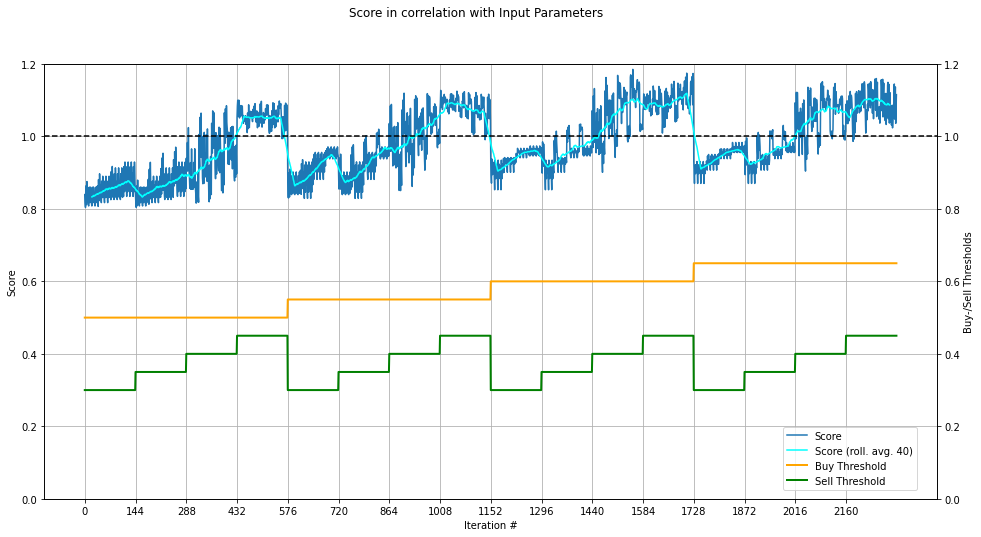

In [ ]:
#Score vs. Thresholds
df_plot=parameters_test_df
df_plot=df_plot.reset_index()

fig,ax1=plt.subplots(figsize=(16,8))
ax2=ax1.twinx()

ax1.plot(df_plot.index,df_plot['score'],label='Score')
ax1.plot(df_plot.index,df_plot['score'].rolling(40,center=True).mean(),label='Score (roll. avg. 40)',color='cyan')
ax2.plot(df_plot.index,df_plot['buy_threshold'],label='Buy Threshold',color='orange',linewidth=2)
ax2.plot(df_plot.index,df_plot['sell_threshold'],label='Sell Threshold',color='green',linewidth=2)
ax1.axhline(1,color='black',linestyle='--')

ax1.set_xlabel('Iteration #')
ax1.set_ylabel('Score')
ax1.set_ylim(0,1.2)
ax2.set_ylim(0,1.2)
ax2.set_ylabel('Buy-/Sell Thresholds')

ax1.set_xticks(range(0,2304,144))
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)
fig.legend(loc='best',bbox_to_anchor=(0.8,0.2))
fig.suptitle('Score in correlation with Input Parameters');

<ipython-input-183-d865182ff8b6>:23: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best',bbox_to_anchor=(0.8,0.2))


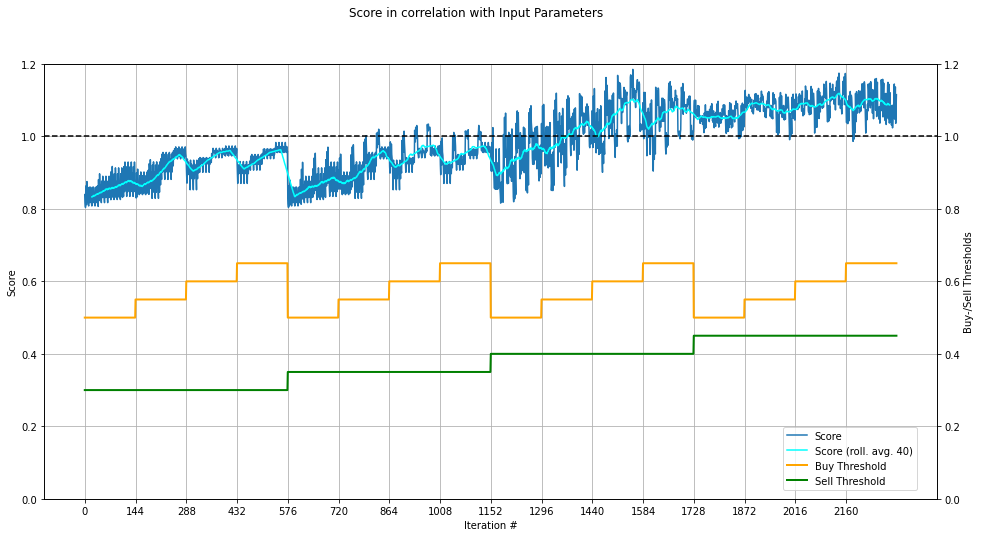

In [ ]:
#Score vs. Thresholds
df_plot=parameters_test_df.sort_values(by=['sell_threshold','buy_threshold'])
df_plot=df_plot.reset_index()

fig,ax1=plt.subplots(figsize=(16,8))
ax2=ax1.twinx()

ax1.plot(df_plot.index,df_plot['score'],label='Score')
ax1.plot(df_plot.index,df_plot['score'].rolling(40,center=True).mean(),label='Score (roll. avg. 40)',color='cyan')
ax2.plot(df_plot.index,df_plot['buy_threshold'],label='Buy Threshold',color='orange',linewidth=2)
ax2.plot(df_plot.index,df_plot['sell_threshold'],label='Sell Threshold',color='green',linewidth=2)
ax1.axhline(1,color='black',linestyle='--')

ax1.set_xlabel('Iteration #')
ax1.set_ylabel('Score')
ax1.set_ylim(0,1.2)
ax2.set_ylim(0,1.2)
ax2.set_ylabel('Buy-/Sell Thresholds')

ax1.set_xticks(range(0,2304,144))
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)
fig.legend(loc='best',bbox_to_anchor=(0.8,0.2))
fig.suptitle('Score in correlation with Input Parameters');

<ipython-input-188-0f630bbb1fbd>:25: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best',bbox_to_anchor=(0.8,0.2))


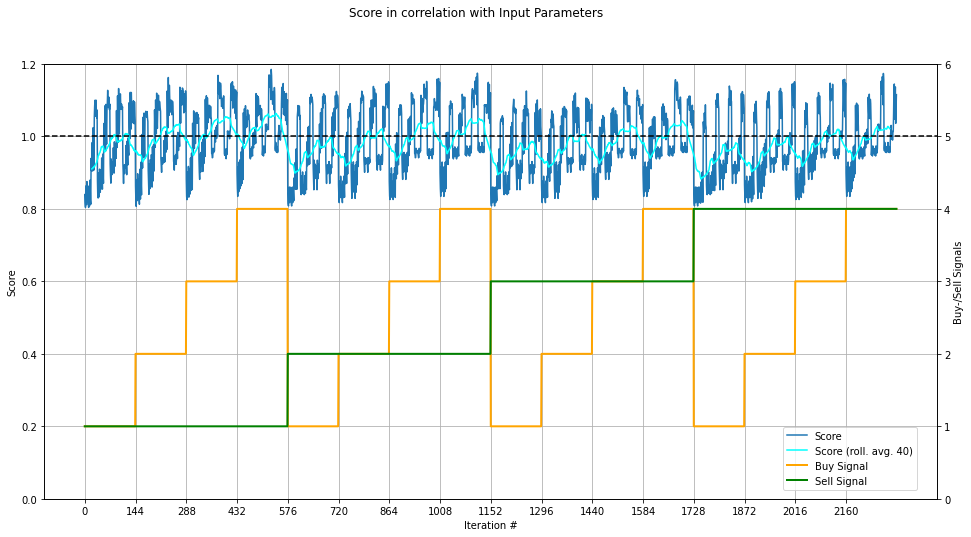

In [ ]:
# Score vs. Signals
df_plot=parameters_test_df.sort_values(by=['sell_signal','buy_signal'])
df_plot=df_plot.reset_index()

fig,ax1=plt.subplots(figsize=(16,8))
ax2=ax1.twinx()

ax1.plot(df_plot.index,df_plot['score'],label='Score')
ax1.plot(df_plot.index,df_plot['score'].rolling(40,center=True).mean(),label='Score (roll. avg. 40)',color='cyan')
ax2.plot(df_plot.index,df_plot['buy_signal'],label='Buy Signal',color='orange',linewidth=2)
ax2.plot(df_plot.index,df_plot['sell_signal'],label='Sell Signal',color='green',linewidth=2)
# ax1.plot(df_plot.index,df_plot['buy_threshold'],label='Buy Signal',color='orange')
# ax1.plot(df_plot.index,df_plot['sell_threshold'],label='Sell Signal',color='green')
ax1.axhline(1,color='black',linestyle='--')

ax1.set_xlabel('Iteration #')
ax1.set_ylabel('Score')
ax1.set_ylim(0,1.2)
ax2.set_ylim(0,6)
ax2.set_ylabel('Buy-/Sell Signals')

ax1.set_xticks(range(0,2304,144))
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)
fig.legend(loc='best',bbox_to_anchor=(0.8,0.2))
fig.suptitle('Score in correlation with Input Parameters');

<ipython-input-192-2c80ee6b8154>:23: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best',bbox_to_anchor=(0.8,0.2))


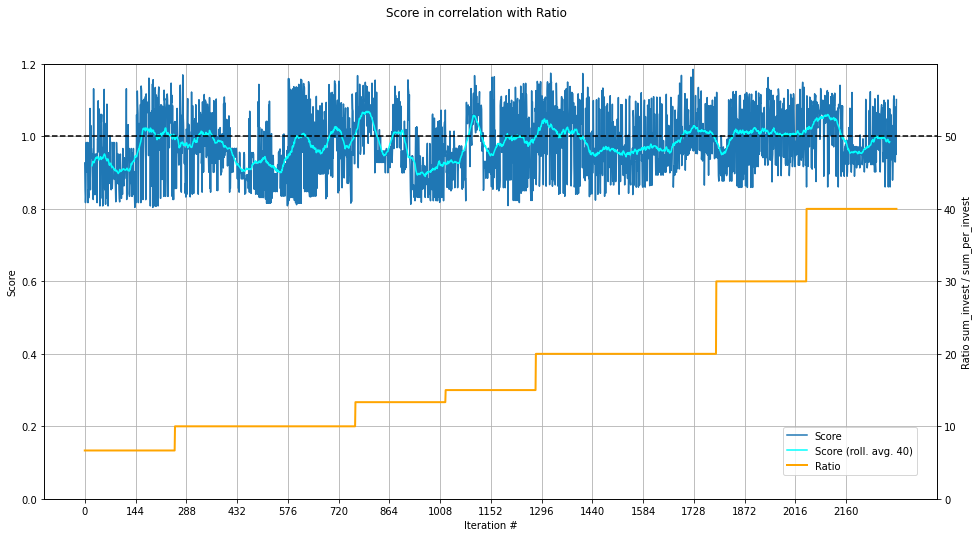

In [ ]:
# Score vs. ratio
df_plot=parameters_test_df.sort_values(by=['ratio'])
df_plot=df_plot.reset_index()

fig,ax1=plt.subplots(figsize=(16,8))
ax2=ax1.twinx()

ax1.plot(df_plot.index,df_plot['score'],label='Score')
ax1.plot(df_plot.index,df_plot['score'].rolling(40,center=True).mean(),label='Score (roll. avg. 40)',color='cyan')
ax2.plot(df_plot.index,df_plot['ratio'],label='Ratio',color='orange',linewidth=2)
ax1.axhline(1,color='black',linestyle='--')

ax1.set_xlabel('Iteration #')
ax1.set_ylabel('Score')
ax1.set_ylim(0,1.2)
ax2.set_ylim(0,60)
ax2.set_yticks(range(0,60,10))
ax2.set_ylabel('Ratio sum_invest / sum_per_invest')

ax1.set_xticks(range(0,2304,144))
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)
fig.legend(loc='best',bbox_to_anchor=(0.8,0.2))
fig.suptitle('Score in correlation with Ratio');

In [ ]:
heat=np.array(parameters_test_df[['buy_threshold','buy_signal','sell_threshold','sell_signal','sum_invest','sum_per_invest','ratio','score']].corr())

In [ ]:
print(heat)

[[ 0.35579152]
 [ 0.22744505]
 [ 0.75040428]
 [-0.13574113]
 [ 0.06585696]
 [-0.1556756 ]
 [ 0.16190025]
 [ 1.        ]]


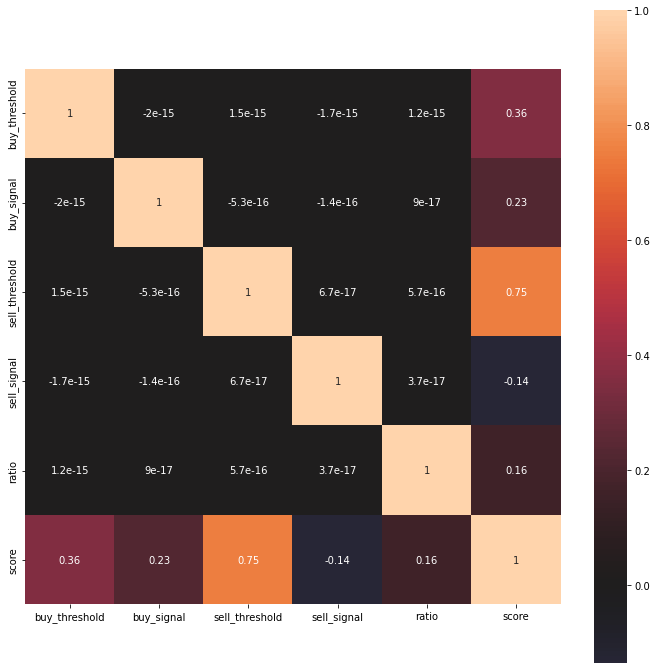

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(parameters_test_df[['buy_threshold','buy_signal','sell_threshold','sell_signal','ratio','score']].corr(),annot=True,center=0,square=True)

# *Test of hyper-parameters pt.2

In [ ]:
buy_thresholds=[0.6,0.65]
sell_thresholds=[0.4,0.45]
buy_signals=[3,4]
sell_signals=[1,2,3]
sums_invest=[20000,25000,30000]
sums_per_invest=[1000,1500,2000]

port_tickers=['HD','AAPL','MSFT']

timestamp=dt.datetime.now().strftime('%Y%m%d_%H%M%S')
print(timestamp)

Yfi_data=get_yfin_data('2022-12-31',port_tickers,delta=400,date_in='2022-01-01')

iterator=1
max_iter=len(buy_thresholds)*len(sell_thresholds)*len(buy_signals)*len(sell_signals)*len(sums_invest)*len(sums_per_invest)

parameters_test_df=pd.DataFrame({'buy_threshold':pd.Series(dtype=int),
                                 'sell_threshold':pd.Series(dtype=int),
                                 'buy_signal':pd.Series(dtype=int),
                                 'sell_signal':pd.Series(dtype=int),
                                 'sum_invest':pd.Series(dtype=int),
                                 'sum_per_invest':pd.Series(dtype=int),
                                 'score':pd.Series(dtype=int)
                                 })

for buy_threshold in buy_thresholds:
  for sell_threshold in sell_thresholds:
    for buy_signal in buy_signals:
      for sell_signal in sell_signals:
        for sum_invest in sums_invest:
          for sum_per_invest in sums_per_invest:
            print(iterator,"of",max_iter)
            iterator +=1
            port=Portfolio(data=Yfi_data,
                          buy_threshold=buy_threshold,
                          sell_threshold=sell_threshold,
                          tickers=port_tickers,
                          buy_signal=buy_signal,
                          sell_signal=sell_signal,
                          sum_per_invest=sum_per_invest,
                          start_invest=sum_invest,
                          silent_mode=True
                          )

            port.load_predictions('FINAL_predictions_all_stocks_20230107_094945')
          
            port.invest('2022-03-01')
            score=port.score()
            new_row=[{'buy_threshold':buy_threshold,
                                 'sell_threshold':sell_threshold,
                                 'buy_signal':buy_signal,
                                 'sell_signal':sell_signal,
                                 'sum_invest':sum_invest,
                                 'sum_per_invest':sum_per_invest,
                                 'score':score
                                 }]
            parameters_test_df=parameters_test_df.append(new_row,ignore_index=True)
            port.print_params()
            port.report()

drive.mount('/drive')
timestamp=dt.datetime.now().strftime('%Y%m%d_%H%M%S')
parameters_test_df.to_csv('/drive/My Drive/OPA/Datasets/portfolio_hyperparameters_2nd_test_'+ timestamp + '.csv')
print("Finished!")
print("Logfile: /drive/My Drive/OPA/Datasets/portfolio_hyperparameters_2nd_test_"+ timestamp + ".csv")

In [ ]:
parameters_test_df=pd.read_csv('/drive/My Drive/OPA/Datasets/portfolio_hyperparameters_2nd_test_20230107_142056.csv')
parameters_test_df.drop(['Unnamed: 0'],inplace=True,axis=1)
parameters_test_df['ratio']=round((parameters_test_df['sum_invest']/parameters_test_df['sum_per_invest']),2)

In [ ]:
display(parameters_test_df.sort_values(by='score',ascending=False).head(10))

,buy_threshold,sell_threshold,buy_signal,sell_signal,sum_invest,sum_per_invest,score,ratio
31,0.60,0.4,4,1,25000,1500,1.188699,16.67
34,0.60,0.4,4,1,30000,1500,1.180869,20.00
27,0.60,0.4,4,1,20000,1000,1.174583,20.00
3,0.60,0.4,3,1,25000,1000,1.174244,25.00
35,0.60,0.4,4,1,30000,2000,1.172892,15.00
110,0.65,0.4,3,1,20000,2000,1.172347,10.00
32,0.60,0.4,4,1,25000,2000,1.167168,12.50
28,0.60,0.4,4,1,20000,1500,1.166832,13.33
30,0.60,0.4,4,1,25000,1000,1.165211,25.00
29,0.60,0.4,4,1,20000,2000,1.164198,10.00


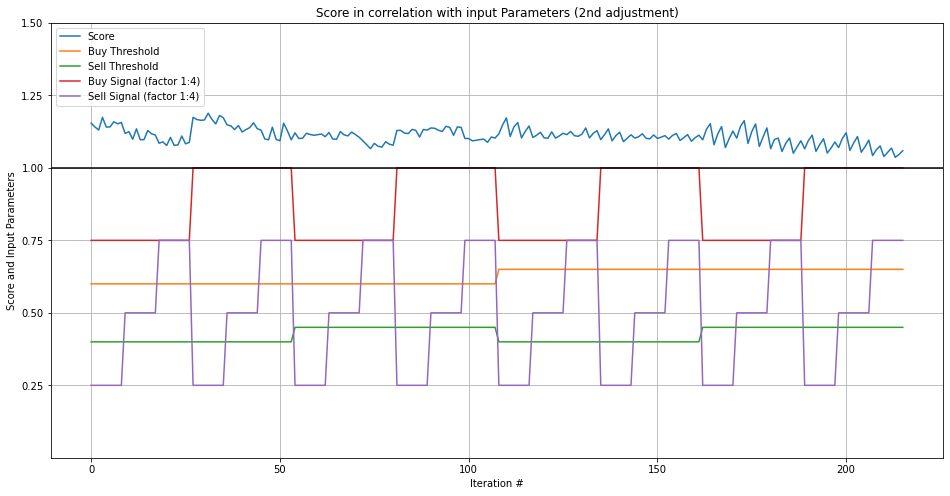

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(parameters_test_df.index,parameters_test_df['score'],label='Score')
plt.plot(parameters_test_df.index,parameters_test_df['buy_threshold'],label='Buy Threshold')
plt.plot(parameters_test_df.index,parameters_test_df['sell_threshold'],label='Sell Threshold')
plt.plot(parameters_test_df.index,parameters_test_df['buy_signal']/4,label='Buy Signal (factor 1:4)')
plt.plot(parameters_test_df.index,parameters_test_df['sell_signal']/4,label='Sell Signal (factor 1:4)')
lt.plot(parameters_test_df.index,parameters_test_df['sum_invest']/parameters_test_df['sum_per_invest']/100,label='Invest amt.p.inv. (factor 1:100)',marker='o')
plt.xlabel('Iteration #')
plt.ylabel('Score and Input Parameters')

plt.yticks([0.25,0.5,0.75,1,1.25,1.5,1.75])
plt.ylim(0,1.5)
plt.grid()
plt.legend(loc='upper left')
plt.title('Score in correlation with input Parameters (2nd adjustment)')
plt.axhline(1,color='black');

In [ ]:
display(parameters_test_df[parameters_test_df['score']>=1.1].describe())

,buy_threshold,sell_threshold,buy_signal,sell_signal,sum_invest,sum_per_invest,score,ratio
count,145.000000,145.00000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,0.623448,0.42000,3.482759,1.779310,25000.000000,1531.034483,1.126106,17.632138
std,0.025038,0.02458,0.501435,0.740392,4124.789557,404.920644,0.020410,5.890885
min,0.600000,0.40000,3.000000,1.000000,20000.000000,1000.000000,1.100216,10.000000
25%,0.600000,0.40000,3.000000,1.000000,20000.000000,1000.000000,1.110040,13.330000
50%,0.600000,0.40000,3.000000,2.000000,25000.000000,1500.000000,1.122100,16.670000
75%,0.650000,0.45000,4.000000,2.000000,30000.000000,2000.000000,1.139627,20.000000
max,0.650000,0.45000,4.000000,3.000000,30000.000000,2000.000000,1.188699,30.000000


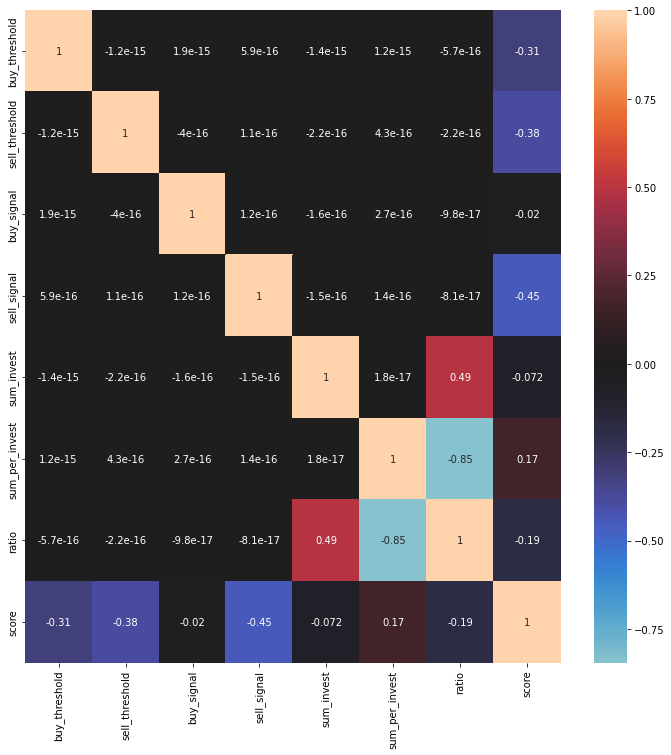

In [ ]:
plt.figure(figsize=(12,12))
parameters_test_df['ratio']=parameters_test_df['sum_invest']/parameters_test_df['sum_per_invest']
parameters_test_df=parameters_test_df[['buy_threshold','sell_threshold','buy_signal','sell_signal','sum_invest','sum_per_invest','ratio','score']]
sns.heatmap(parameters_test_df.corr(),annot=True,center=0)

# *Test of best hyper-parameters pt.3

In [ ]:
buy_thresholds=[0.62]
sell_thresholds=[0.42]
buy_signals=[3]
sell_signals=[1]
sums_invest=[25000]
sums_per_invest=[1500]

port_tickers=['HD','AAPL','MSFT']

timestamp=dt.datetime.now().strftime('%Y%m%d_%H%M%S')
print(timestamp)

Yfi_data=get_yfin_data('2022-12-31',port_tickers,delta=400,date_in='2022-01-01')

iterator=1
max_iter=len(buy_thresholds)*len(sell_thresholds)*len(buy_signals)*len(sell_signals)*len(sums_invest)*len(sums_per_invest)

parameters_test_df=pd.DataFrame({'buy_threshold':pd.Series(dtype=int),
                                 'sell_threshold':pd.Series(dtype=int),
                                 'buy_signal':pd.Series(dtype=int),
                                 'sell_signal':pd.Series(dtype=int),
                                 'sum_invest':pd.Series(dtype=int),
                                 'sum_per_invest':pd.Series(dtype=int),
                                 'score':pd.Series(dtype=int)
                                 })

for buy_threshold in buy_thresholds:
  for sell_threshold in sell_thresholds:
    for buy_signal in buy_signals:
      for sell_signal in sell_signals:
        for sum_invest in sums_invest:
          for sum_per_invest in sums_per_invest:
            print(iterator,"of",max_iter)
            iterator +=1
            port=Portfolio(data=Yfi_data,
                          buy_threshold=buy_threshold,
                          sell_threshold=sell_threshold,
                          tickers=port_tickers,
                          buy_signal=buy_signal,
                          sell_signal=sell_signal,
                          sum_per_invest=sum_per_invest,
                          start_invest=sum_invest,
                          silent_mode=True
                          )

            port.load_predictions('FINAL_predictions_all_stocks_20230107_094945')
          
            port.invest('2022-03-01')
            score=port.score()
            new_row=[{'buy_threshold':buy_threshold,
                                 'sell_threshold':sell_threshold,
                                 'buy_signal':buy_signal,
                                 'sell_signal':sell_signal,
                                 'sum_invest':sum_invest,
                                 'sum_per_invest':sum_per_invest,
                                 'score':score
                                 }]
            parameters_test_df=parameters_test_df.append(new_row,ignore_index=True)
            port.print_params()
            port.report()
            port.graphical_report()

drive.mount('/drive')
timestamp=dt.datetime.now().strftime('%Y%m%d_%H%M%S')
parameters_test_df.to_csv('/drive/My Drive/OPA/Datasets/portfolio_hyperparameters_3nd_test_'+ timestamp + '.csv')
print("Finished!")
print("Logfile: /drive/My Drive/OPA/Datasets/portfolio_hyperparameters_3nd_test_"+ timestamp + ".csv")

In [ ]:
parameters_test_df=pd.read_csv('/drive/My Drive/OPA/Datasets/portfolio_hyperparameters_3rd_test_20230107_161927.csv')
parameters_test_df.drop(['Unnamed: 0'],inplace=True,axis=1)
parameters_test_df['ratio']=round((parameters_test_df['sum_invest']/parameters_test_df['sum_per_invest']),2)

In [ ]:
display(parameters_test_df)

,buy_threshold,sell_threshold,buy_signal,sell_signal,sum_invest,sum_per_invest,score,ratio
0,0.62,0.42,3,1,25000,1500,1.237465,16.67


# *Test with all ticker combinations

In [ ]:
# 3 Tickers
buy_thresholds=[0.62]
sell_thresholds=[0.42]
buy_signals=[3]
sell_signals=[1]
sums_invest=[25000]
sums_per_invest=[1500]

timestamp=dt.datetime.now().strftime('%Y%m%d_%H%M%S')
print(timestamp)

# Build array with all ticker combinations
ticker_array=np.array(list(itertools.combinations(list(tickers.keys()),3)))

Yfi_data=get_yfin_data('2022-12-31',port_tickers,delta=400,date_in='2022-01-01')

iterator=1

# Time measurement for remaining time calculation
total_time=0

max_iter=len(buy_thresholds)*len(sell_thresholds)*len(buy_signals)*len(sell_signals)*len(sums_invest)*len(sums_per_invest)*len(ticker_array)

parameters_test_df=pd.DataFrame({'buy_threshold':pd.Series(dtype=int),
                                 'sell_threshold':pd.Series(dtype=int),
                                 'buy_signal':pd.Series(dtype=int),
                                 'sell_signal':pd.Series(dtype=int),
                                 'sum_invest':pd.Series(dtype=int),
                                 'sum_per_invest':pd.Series(dtype=int),
                                 'score':pd.Series(dtype=int),
                                 'tickers':pd.Series(dtype=str)
                                 })

for buy_threshold in buy_thresholds:
  for sell_threshold in sell_thresholds:
    for buy_signal in buy_signals:
      for sell_signal in sell_signals:
        for sum_invest in sums_invest:
          for sum_per_invest in sums_per_invest:
            for tickers_iter in ticker_array:
              print(iterator,"of",max_iter)
              t_start=timeit.default_timer()

              port=Portfolio(data=Yfi_data,
                            buy_threshold=buy_threshold,
                            sell_threshold=sell_threshold,
                            tickers=tickers_iter,
                            buy_signal=buy_signal,
                            sell_signal=sell_signal,
                            sum_per_invest=sum_per_invest,
                            start_invest=sum_invest,
                            silent_mode=True
                            )

              #port.predict()
              port.load_predictions('FINAL_predictions_all_stocks_20230107_094945')
            
              port.invest('2022-03-01')
              score=port.score()
              ticker_string=' '.join(tickers_iter)
              new_row=[{'buy_threshold':buy_threshold,
                                  'sell_threshold':sell_threshold,
                                  'buy_signal':buy_signal,
                                  'sell_signal':sell_signal,
                                  'sum_invest':sum_invest,
                                  'sum_per_invest':sum_per_invest,
                                  'score':score,
                                  'tickers':ticker_string
                                  }]
              parameters_test_df=parameters_test_df.append(new_row,ignore_index=True)
              port.print_params()
              port.report()
              t_stop=timeit.default_timer()
              runtime=t_stop-t_start
              total_time+=runtime
              iter_left=max_iter-iterator
              mean_time=total_time / iterator
              remaining_time=iter_left * mean_time
              print('Estimated remaining time:',timedelta(seconds=remaining_time))
              iterator+=1

drive.mount('/drive')
timestamp=dt.datetime.now().strftime('%Y%m%d_%H%M%S')
path='/drive/My Drive/OPA/Datasets/portfolio_all_tickers_test_'+ timestamp + '.csv'
parameters_test_df.to_csv(path)
print("Finished!")
print("Logfile:",path)

In [ ]:
parameters_test_df=pd.read_csv('/drive/My Drive/OPA/Datasets/portfolio_all_tickers_test_20230107_174506.csv')
parameters_test_df.drop(['Unnamed: 0'],inplace=True,axis=1)
parameters_test_df['ratio']=round((parameters_test_df['sum_invest']/parameters_test_df['sum_per_invest']),2)

In [ ]:
# Creating indicator columns for each ticker

ticker=tickers.keys()

def create_ticker_column(input,ticker):
  tick_1=' ' + ticker
  tick_2=ticker + ' '
  if tick_1 in input:
    return 1
  elif tick_2 in input:
    return 1
  else:
    return 0

for ticker in tickers:
  parameters_test_df[ticker]=parameters_test_df.apply(lambda x: create_ticker_column(x['tickers'],ticker),axis=1)

In [ ]:
display(parameters_test_df[parameters_test_df['score']>1.35].sort_values(by='score',ascending=False)[['tickers','score']].head(10))

,tickers,score
40,AAPL UNH XOM,1.403505
77,AAPL XOM PG,1.400071
57,AAPL V XOM,1.399109
70,AAPL NVDA XOM,1.398198
80,AAPL XOM HD,1.392917
378,V NVDA XOM,1.388673
421,NVDA XOM PG,1.387645
424,NVDA XOM HD,1.384721
321,UNH XOM PG,1.383000
135,MSFT V XOM,1.381621


<ipython-input-19-2f52836fbdf2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['score']=parameters_test_df['score']


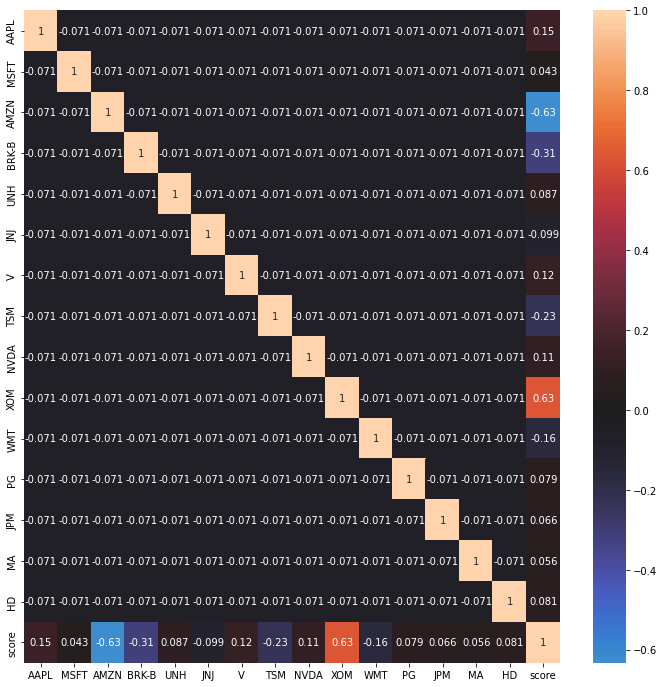

In [ ]:
plt.figure(figsize=(12,12))
df_corr=parameters_test_df[tickers.keys()]
df_corr['score']=parameters_test_df['score']
sns.heatmap(df_corr.corr(),annot=True,center=0);

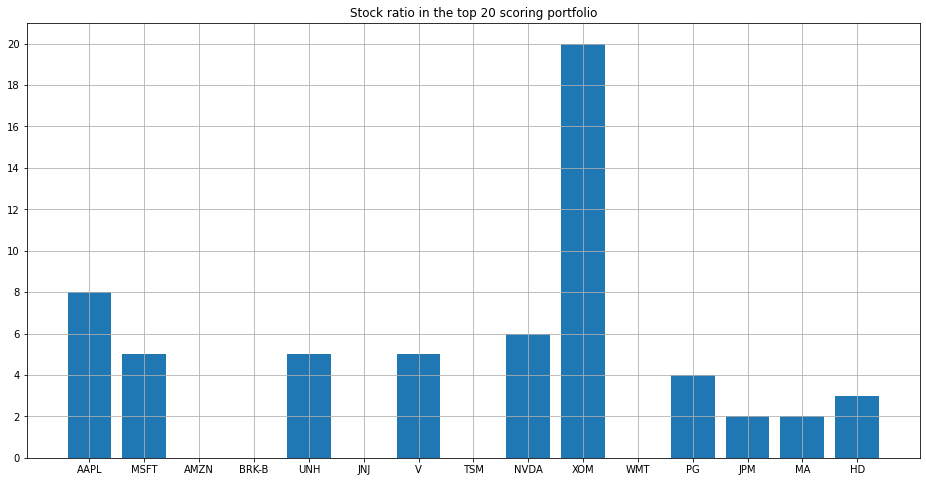

In [ ]:
correlation_sorted_limited=df_corr.sort_values('score',ascending=False)[tickers.keys()].head(20).sum()

plt.figure(figsize=(16,8))
plt.bar(correlation_sorted_limited.index,correlation_sorted_limited.values)
plt.grid()
plt.title('Stock ratio in the top 20 scoring portfolio')
plt.yticks(np.arange(0,22,2))
plt.xticks(rotation=0);

In [ ]:
parameters_test_df[(parameters_test_df['AAPL']+parameters_test_df['V']+parameters_test_df['NVDA']+parameters_test_df['PG']+parameters_test_df['JPM']+parameters_test_df['XOM'])==3][['tickers','BRK-B','WMT','JPM','MA','score']].sort_values(by='score',ascending=False)

# Showing best combination



Getting YFinance Data. Date-in: 2022-01-01 Date-out: 2022-12-31
--------------------------------------------------------------------
HD
AAPL
MSFT
Finished getting YFinance Data!
Runtime: 1.14s
--------------------------------------------------------------------
Ratio: 16.67
11.01.2023 18:08:32  - Starting Prepare
stock_feature_generator(ticker='HD')
stock_feature_generator(ticker='AAPL')
stock_feature_generator(ticker='MSFT')
Data Preparation finished!
--------------------------------------------------------------------
11.01.2023 18:08:32  - Loading pre-fitted estimators
Loading Estimator: HD
Loading Estimator: AAPL
Loading Estimator: MSFT
Loaded all estimators!
--------------------------------------------------------------------
11.01.2023 18:08:38  - Starting Prediction
Predicting Stock: HD
Prediction finished! 1: 137 , 0: 95
Predicting Stock: AAPL
Prediction finished! 1: 137 , 0: 95
Predicting Stock: MSFT
Prediction finished! 1: 169 , 0: 63
Runtime: 2.22s
--------------------------

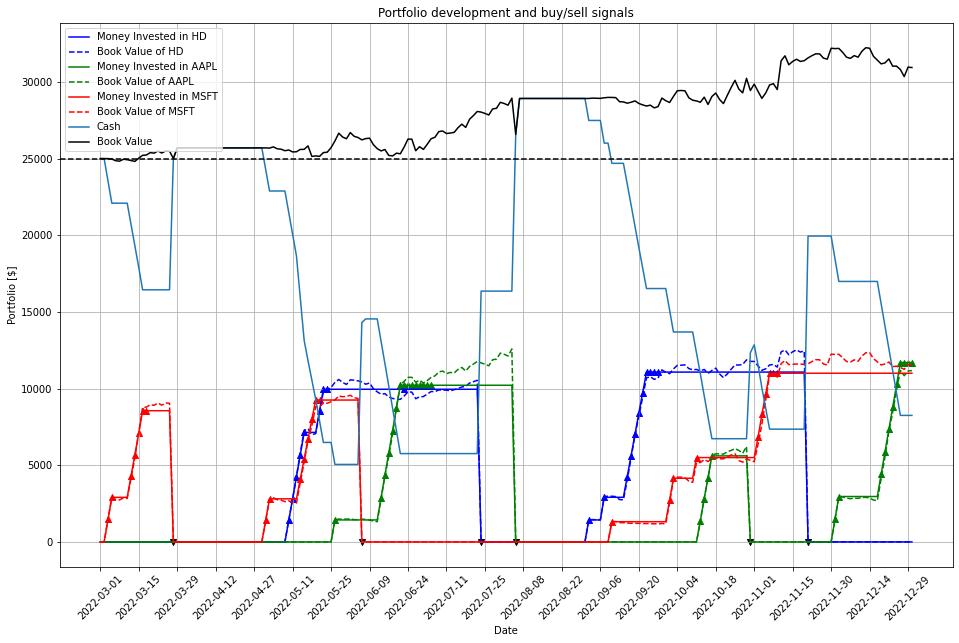

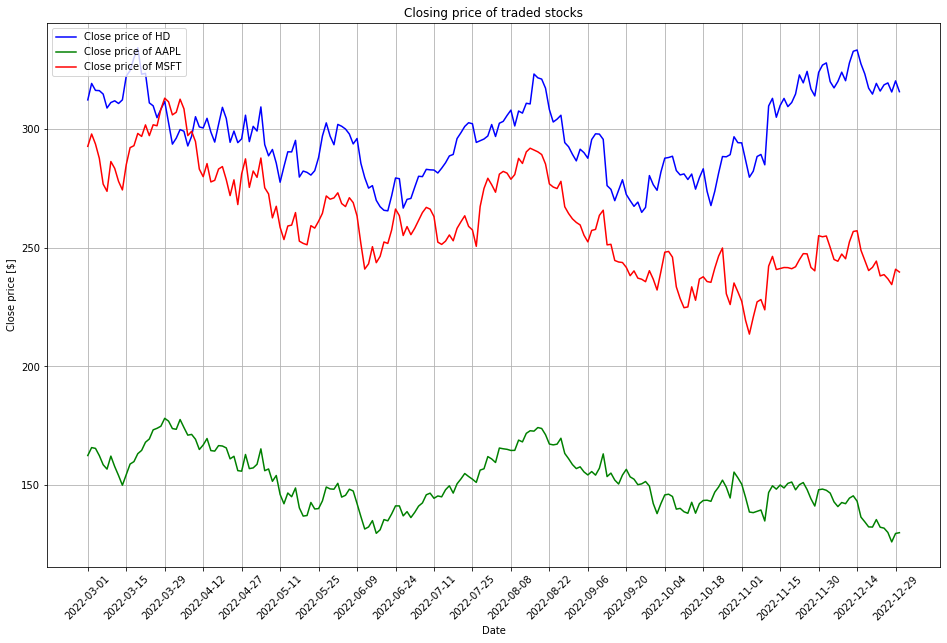

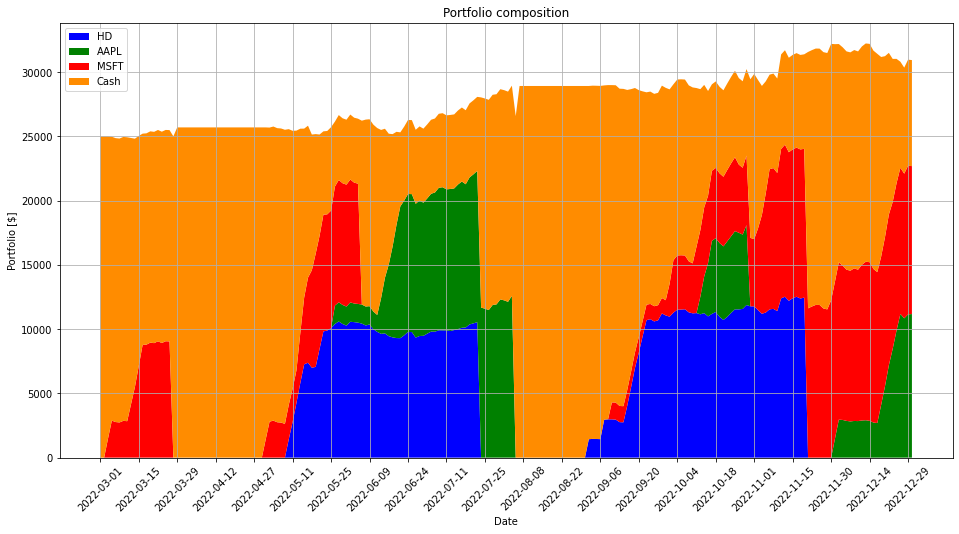

In [ ]:
buy_thresholds=0.62
sell_thresholds=0.42
buy_signals=3
sell_signals=1
sums_invest=25000
sums_per_invest=1500

# Create the object and run prepare and predict
port_tickers=['HD','AAPL','MSFT']

port=Portfolio(data=get_yfin_data('2022-12-31',port_tickers,delta=400,date_in='2022-01-01'),
               buy_threshold=buy_thresholds,
               sell_threshold=sell_thresholds,
               tickers=port_tickers,
               buy_signal=buy_signals,
               sell_signal=sell_signals,
               sum_per_invest=sums_per_invest,
               start_invest=sums_invest,
               silent_mode=True
               )

port.predict()

port.invest('2022-03-01')

port.print_params()

port.report()

port.graphical_report()

# *Dependency on start date ['AAPL','MSFT','HD']

In [ ]:
buy_thresholds=[0.62]
sell_thresholds=[0.42]
buy_signals=[3]
sell_signals=[1]
sums_invest=[25000]
sums_per_invest=[1500]

port_tickers=['HD','AAPL','MSFT']

timestamp=dt.datetime.now().strftime('%Y%m%d_%H%M%S')
print(timestamp)

# time array generation
step=7
start_date='2022-02-01'
start_date=dt.datetime.strptime(start_date,'%Y-%m-%d')
time_array=[]
for i in range(15):
  date_in=start_date + dt.timedelta(days=step*i)
  time_array.append(date_in.strftime('%Y-%m-%d'))

iterator=1

# Time measurement for remaining time calculation
total_time=0

max_iter=len(buy_thresholds)*len(sell_thresholds)*len(buy_signals)*len(sell_signals)*len(sums_invest)*len(sums_per_invest)*len(time_array)

parameters_test_df=pd.DataFrame({'date_in':pd.Series(dtype=str),
                                 'buy_threshold':pd.Series(dtype=int),
                                 'sell_threshold':pd.Series(dtype=int),
                                 'buy_signal':pd.Series(dtype=int),
                                 'sell_signal':pd.Series(dtype=int),
                                 'sum_invest':pd.Series(dtype=int),
                                 'sum_per_invest':pd.Series(dtype=int),
                                 'score':pd.Series(dtype=int)
                                 })

for buy_threshold in buy_thresholds:
  for sell_threshold in sell_thresholds:
    for buy_signal in buy_signals:
      for sell_signal in sell_signals:
        for sum_invest in sums_invest:
          for sum_per_invest in sums_per_invest:
            for date_in in time_array:
              print(iterator,"of",max_iter)
              t_start=timeit.default_timer()
              Yfi_data=get_yfin_data('2022-12-31',port_tickers,delta=400,date_in=date_in)
              port=Portfolio(data=Yfi_data,
                            buy_threshold=buy_threshold,
                            sell_threshold=sell_threshold,
                            tickers=port_tickers,
                            buy_signal=buy_signal,
                            sell_signal=sell_signal,
                            sum_per_invest=sum_per_invest,
                            start_invest=sum_invest,
                            silent_mode=True
                            )

              port.load_predictions('FINAL_predictions_all_stocks_20230107_094945')
            
              port.invest(date_in)
              score=port.score()
              new_row=[{'date_in':date_in,
                                  'buy_threshold':buy_threshold,
                                  'sell_threshold':sell_threshold,
                                  'buy_signal':buy_signal,
                                  'sell_signal':sell_signal,
                                  'sum_invest':sum_invest,
                                  'sum_per_invest':sum_per_invest,
                                  'score':score
                                  }]
              parameters_test_df=parameters_test_df.append(new_row,ignore_index=True)
              port.print_params()
              port.report()
              t_stop=timeit.default_timer()
              runtime=t_stop-t_start
              total_time+=runtime
              iter_left=max_iter-iterator
              mean_time=total_time / iterator
              remaining_time=iter_left * mean_time
              print('Estimated remaining time:',timedelta(seconds=remaining_time))
              iterator+=1

timestamp=dt.datetime.now().strftime('%Y%m%d_%H%M%S')
path='/drive/My Drive/OPA/Datasets/portfolio_start_date_dependency_'+ timestamp + '.csv'
parameters_test_df.to_csv(path)
print("Finished!")
print("Logfile:",path)

In [ ]:
parameters_test_df=pd.read_csv('/drive/My Drive/OPA/Datasets/portfolio_start_date_dependency_20230107_175933.csv')
parameters_test_df['date_in']=pd.to_datetime(parameters_test_df['date_in'])
parameters_test_df.drop(['Unnamed: 0'],inplace=True,axis=1)
parameters_test_df.set_index('date_in',inplace=True)
parameters_test_df['ratio']=round((parameters_test_df['sum_invest']/parameters_test_df['sum_per_invest']),2)

In [ ]:
display(parameters_test_df.reset_index()[['date_in','score']])

,date_in,score
0,2022-02-01,1.231191
1,2022-02-08,1.230116
2,2022-02-15,1.234764
3,2022-02-22,1.234764
4,2022-03-01,1.237465
5,2022-03-08,1.233466
6,2022-03-15,1.210288
7,2022-03-22,1.196232
8,2022-03-29,1.196232
9,2022-04-05,1.196232


Text(0.5, 1.0, 'Score as a function of invest start date')

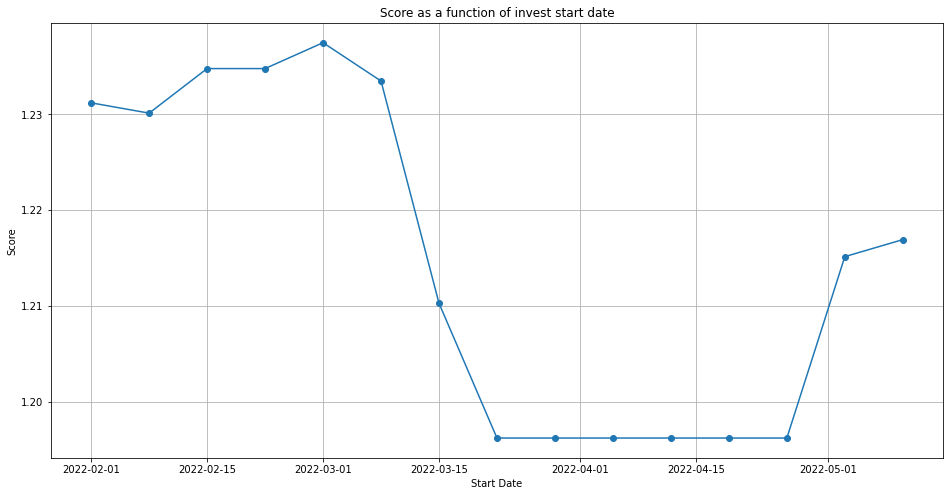

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(parameters_test_df.index,parameters_test_df['score'],marker='o')
plt.xlabel('Start Date')
plt.ylabel('Score')
plt.grid()
plt.title('Score as a function of invest start date')

# *Invest over a 10 year period (this includes data that was used for training!!!)

Getting YFinance Data. Date-in: 2010-01-04 Date-out: 2022-12-31
--------------------------------------------------------------------
HD
AAPL
MSFT
Finished getting YFinance Data!
Runtime: 0.83s
--------------------------------------------------------------------
Ratio: 16.67
11.01.2023 07:41:58  - Starting Prepare
stock_feature_generator(ticker='HD')
stock_feature_generator(ticker='AAPL')
stock_feature_generator(ticker='MSFT')
Data Preparation finished!
--------------------------------------------------------------------
11.01.2023 07:42:03  - Loading pre-fitted estimators
Loading Estimator: HD
Loading Estimator: AAPL
Loading Estimator: MSFT
Loaded all estimators!
--------------------------------------------------------------------
11.01.2023 07:42:05  - Starting Prediction
Predicting Stock: HD
Prediction finished! 1: 2706 , 0: 547
Predicting Stock: AAPL
Prediction finished! 1: 2611 , 0: 642
Predicting Stock: MSFT
Prediction finished! 1: 2754 , 0: 499
Runtime: 3.44s
--------------------

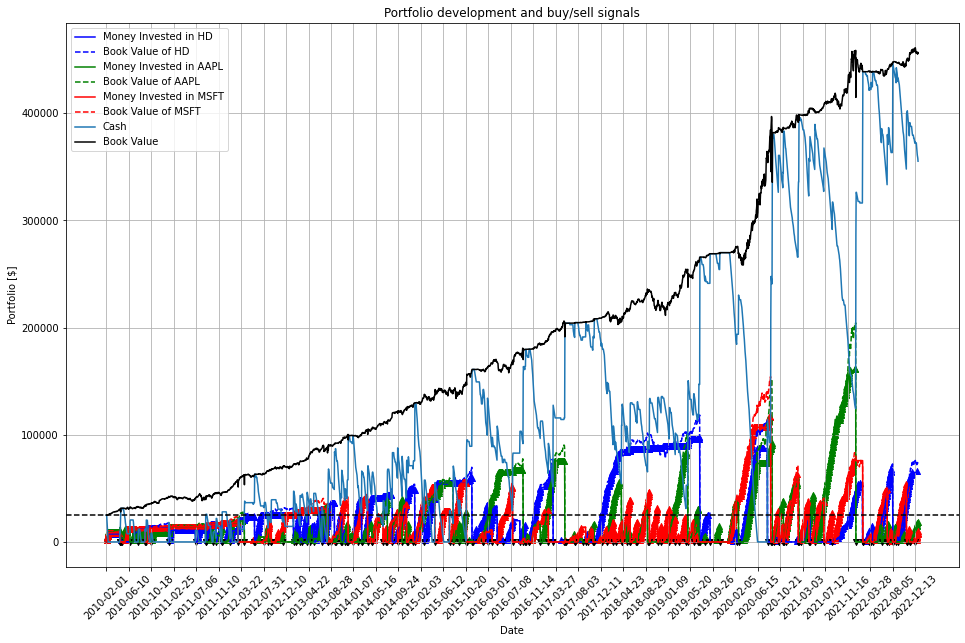

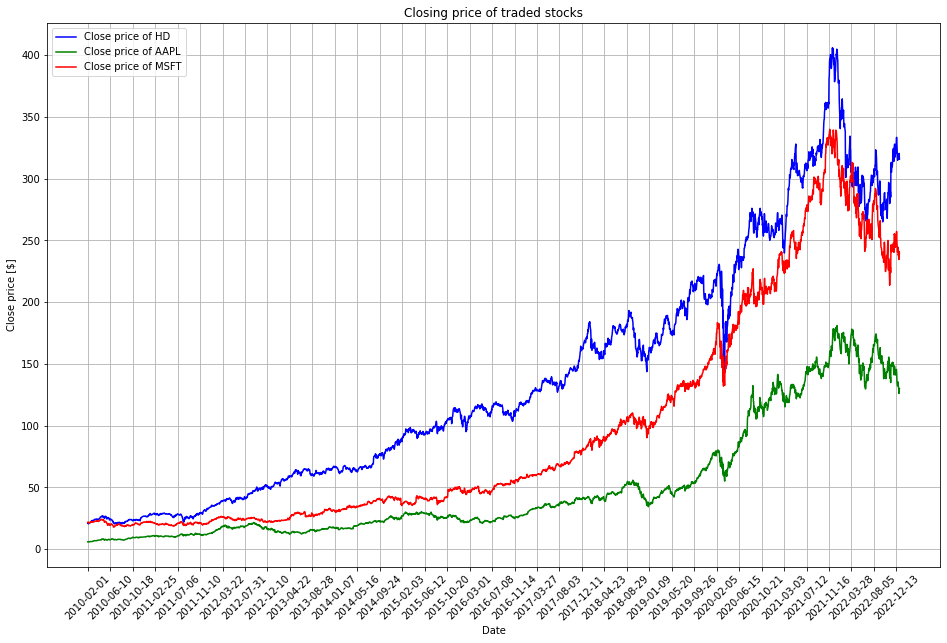

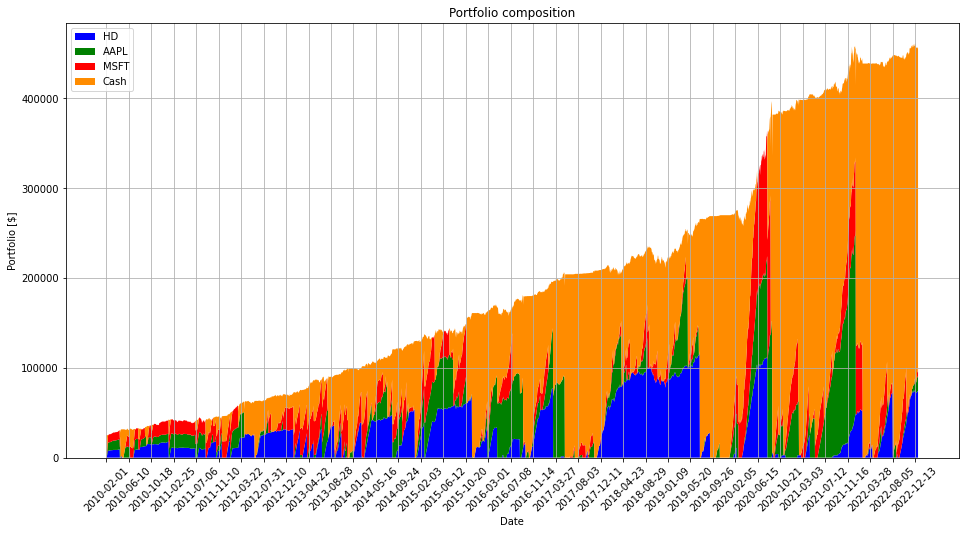

In [ ]:
buy_threshold=0.62
sell_threshold=0.42
buy_signal=3
sell_signal=1
sum_invest=25000
sum_per_invest=1500

port_tickers=['HD','AAPL','MSFT']

Yfi_data=get_yfin_data('2022-12-31',port_tickers,delta=400,date_in='2010-01-04')

port=Portfolio(data=Yfi_data,
              buy_threshold=buy_threshold,
              sell_threshold=sell_threshold,
              tickers=port_tickers,
              buy_signal=buy_signal,
              sell_signal=sell_signal,
              sum_per_invest=sum_per_invest,
              start_invest=sum_invest,
              silent_mode=True
              )

port.predict()

port.invest('2010-01-04')

port.print_params()

port.report()

port.graphical_report(length=90)

In [ ]:
print(port.portfolio)

       inv_qty  mean_stock_val       inv_cash  composition  buy_signal  \
Stock                                                                    
Cash         1        0.000000      86.674852     0.000120           0   
HD        1045      274.369310  286715.928467     0.398391           1   
AAPL      1981      144.910828  287068.350449     0.398880           3   
MSFT       600      243.024148  145814.488785     0.202609           9   

       sell_signal  total_buy  total_sell  exec_buy  exec_sell  
Stock                                                           
Cash             0          0           0         0          0  
HD               0       2025         235       154         41  
AAPL             0       1716         276       223         57  
MSFT             0       1803         224       199         55  


# First Portfolio run with self adjustment [AAPL,MSFT,HD]

Getting YFinance Data. Date-in: 2022-01-01 Date-out: 2022-12-31
--------------------------------------------------------------------
HD
AAPL
MSFT
Finished getting YFinance Data!
Runtime: 0.51s
--------------------------------------------------------------------
Ratio: 10.0
--------------------------------------------------------------------
07.01.2023 22:39:38  - Starting Invest (start date: 2022-03-01 )
Invest Finished!
BuyT: 0.65 | BuyS: 3 | SellT: 0.4 | SellS: 1 | StInv: 10000 | SpI: 1000 | Tickers: ['HD', 'AAPL', 'MSFT']
Score: 1.16 | Book value: 11586.34 | Runtime: 3.62s
Total runtime: 3.65s
--------------------------------------------------------------------------------------------------------------


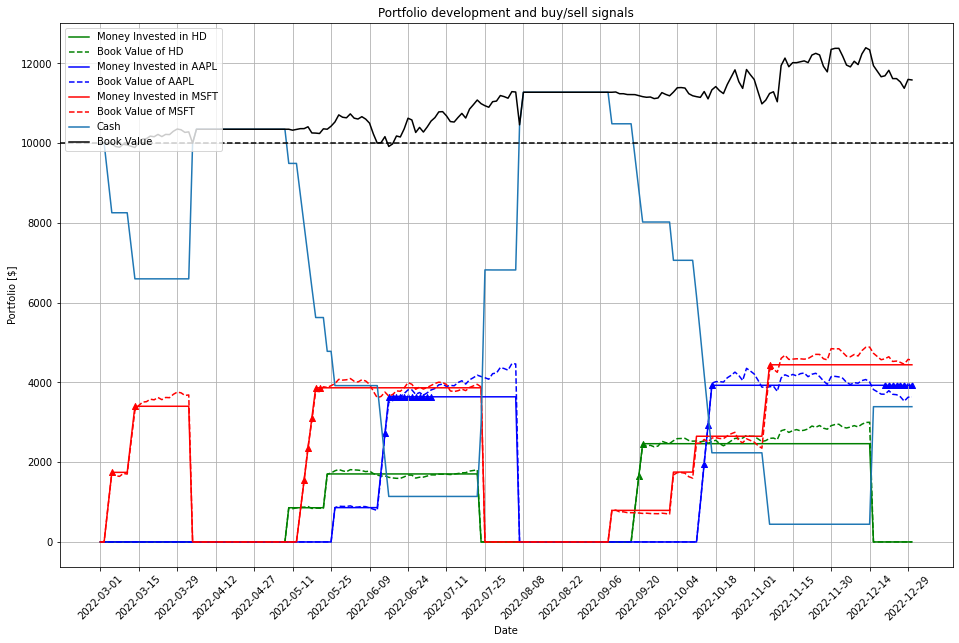

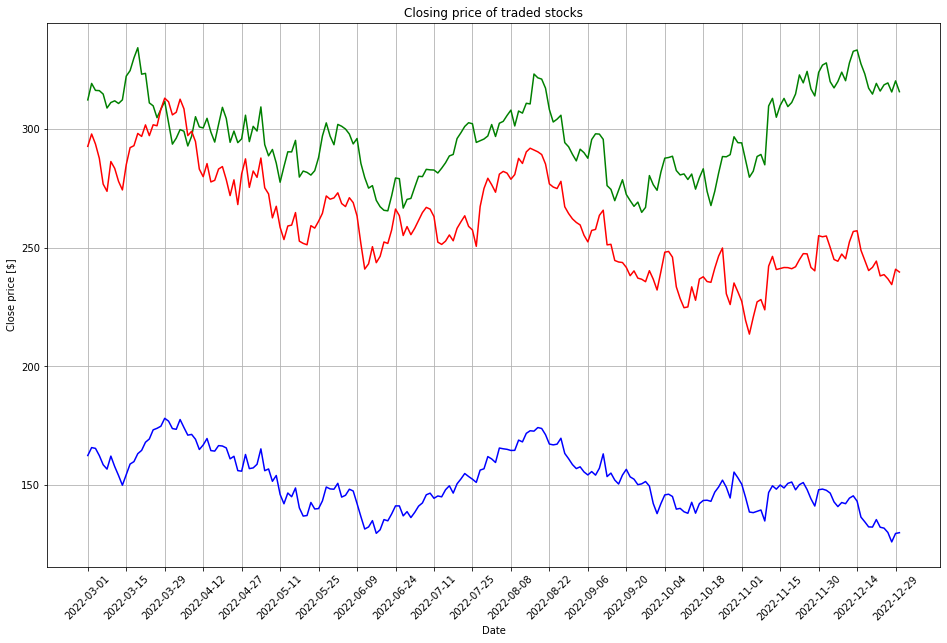

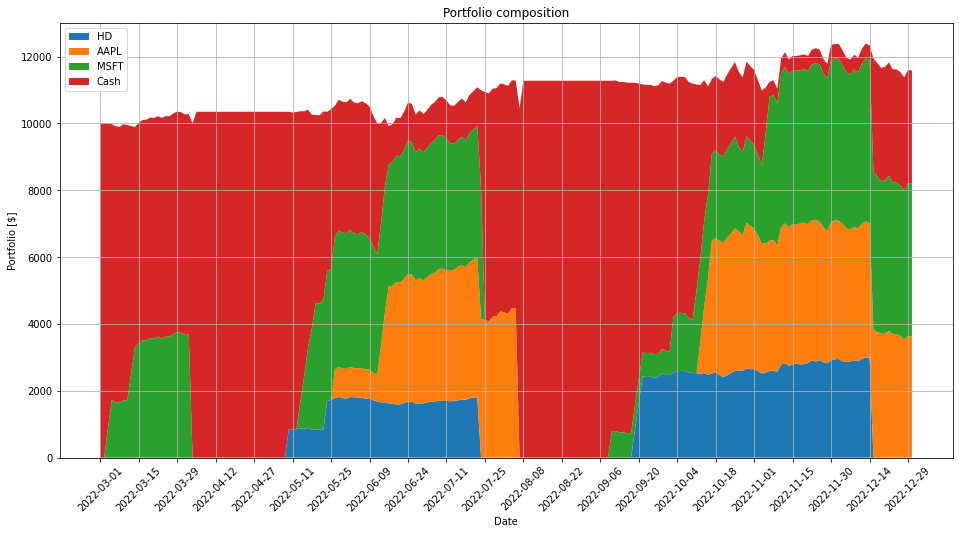

In [ ]:
# Create the object and run prepare and predict
port_tickers=['HD','AAPL','MSFT']
port=Portfolio(data=get_yfin_data('2022-12-31',port_tickers,delta=400,date_in='2022-01-01'),
               buy_threshold=0.65,
               sell_threshold=0.4,
               tickers=port_tickers,
               buy_signal=3,
               sell_signal=1,
               sum_per_invest=1000,
               start_invest=10000,
               silent_mode=True,
               self_adjust=False
               )

# Final predictions
port.load_predictions('FINAL_predictions_all_stocks_20230107_094945') #Erzeugt mit prepare_old, fill_ticker_old, predict_old

port.invest('2022-03-01')

port.print_params()

port.report()

port.graphical_report()

In [ ]:
print(port.logfile)

           Date Stock  Buy_Signal  Sell_Signal Action  inv_qty_cum  \
0    2022-03-01  MSFT           1            0      -            0   
1    2022-03-01    HD           0            0      -            0   
2    2022-03-01  AAPL           0            0      -            0   
3    2022-03-02  MSFT           2            0      -            0   
4    2022-03-02  AAPL           0            0      -            0   
..          ...   ...         ...          ...    ...          ...   
631  2022-12-29  MSFT           0            0      -           19   
632  2022-12-29    HD           0            0      -            0   
633  2022-12-30  AAPL          11            0      -           28   
634  2022-12-30  MSFT           0            0      -           19   
635  2022-12-30    HD           0            0      -            0   

     inv_cash_cum  mean_stock_val       Close    Port_total   Book_value  
0        0.000000        0.000000  292.816162  10000.000000     0.000000  
1        

In [ ]:
port.portfolio['inv_cash'].sum()

11762.544692993164

# *Invest over a 10 year period with self adjustment of sum_per_invest (this includes data that was used for training!!!)

Getting YFinance Data. Date-in: 2010-01-04 Date-out: 2022-12-31
--------------------------------------------------------------------
HD
AAPL
MSFT
Finished getting YFinance Data!
Runtime: 0.92s
--------------------------------------------------------------------
Ratio: 16.67
11.01.2023 08:20:08  - Starting Prepare
stock_feature_generator(ticker='HD')
stock_feature_generator(ticker='AAPL')
stock_feature_generator(ticker='MSFT')
Data Preparation finished!
--------------------------------------------------------------------
11.01.2023 08:20:13  - Loading pre-fitted estimators
Loading Estimator: HD
Loading Estimator: AAPL
Loading Estimator: MSFT
Loaded all estimators!
--------------------------------------------------------------------
11.01.2023 08:20:15  - Starting Prediction
Predicting Stock: HD
Prediction finished! 1: 2706 , 0: 547
Predicting Stock: AAPL
Prediction finished! 1: 2611 , 0: 642
Predicting Stock: MSFT
Prediction finished! 1: 2754 , 0: 499
Runtime: 3.63s
--------------------

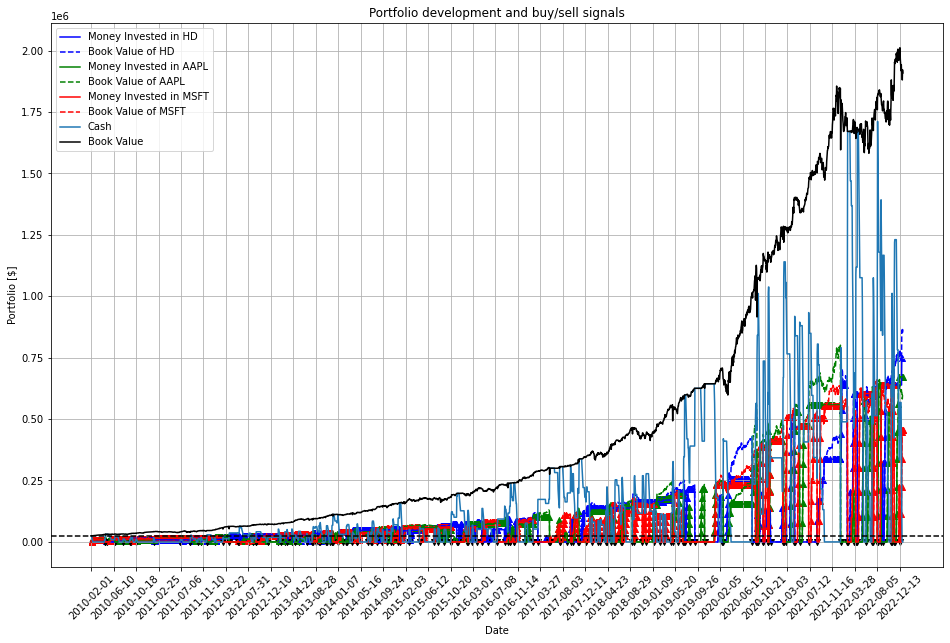

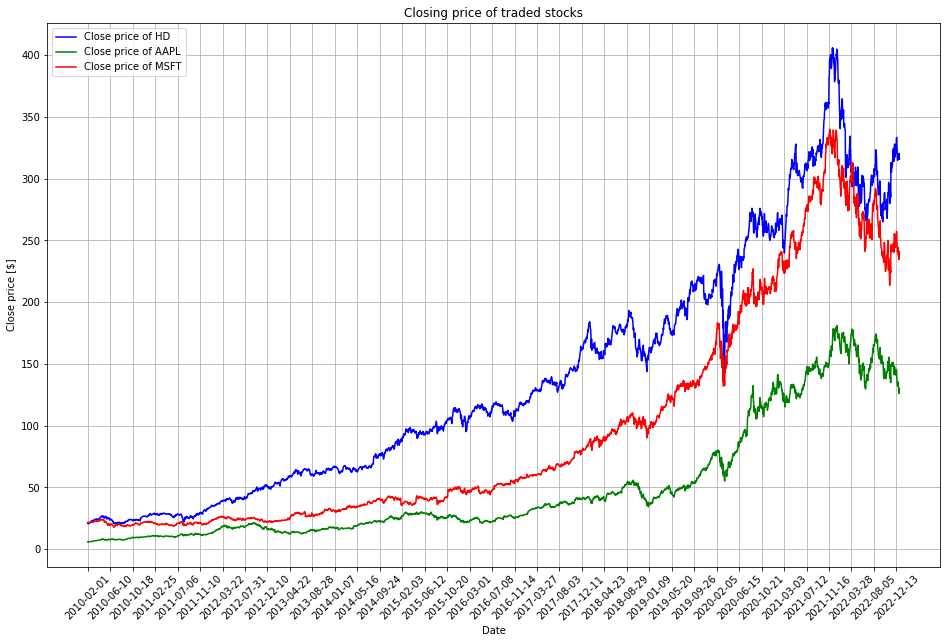

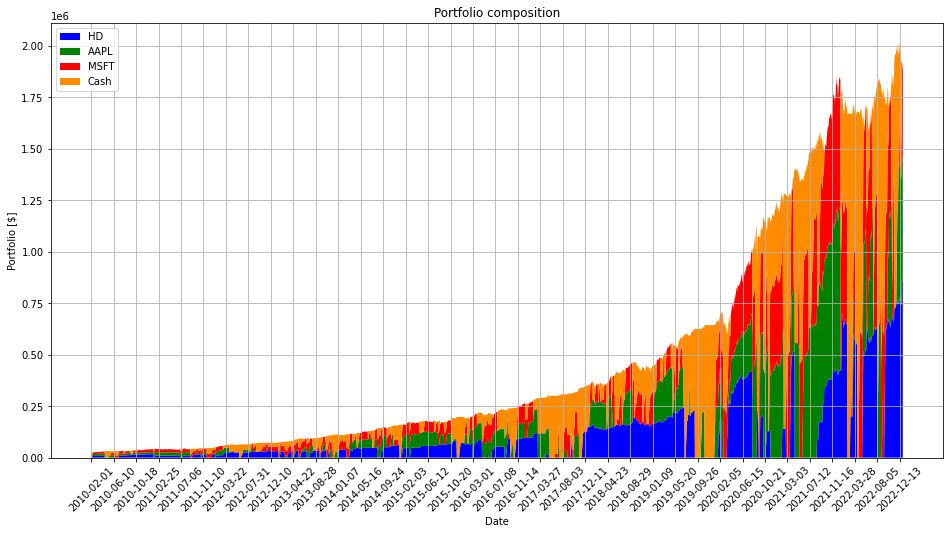

In [ ]:
buy_threshold=0.62
sell_threshold=0.42
buy_signal=3
sell_signal=1
sum_invest=25000
sum_per_invest=1500

port_tickers=['HD','AAPL','MSFT']

Yfi_data=get_yfin_data('2022-12-31',port_tickers,delta=400,date_in='2010-01-04')

port=Portfolio(data=Yfi_data,
              buy_threshold=buy_threshold,
              sell_threshold=sell_threshold,
              tickers=port_tickers,
              buy_signal=buy_signal,
              sell_signal=sell_signal,
              sum_per_invest=sum_per_invest,
              start_invest=sum_invest,
              silent_mode=True,
              self_adjust=True
              )

port.predict()

port.invest('2010-01-04')

port.print_params()

port.report()

port.graphical_report(length=90)

In [ ]:
save_csv_df(port.logfile,'logfile_portfolio_12yrs_without_self_adjust')
save_csv_df(port.portfolio,'portfolio_portfolio_12yrs_without_self_adjust')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


# COVID-19 crash stack-plot

<ipython-input-90-fe2728c5151f>:45: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best',bbox_to_anchor=(0.85,0.2))


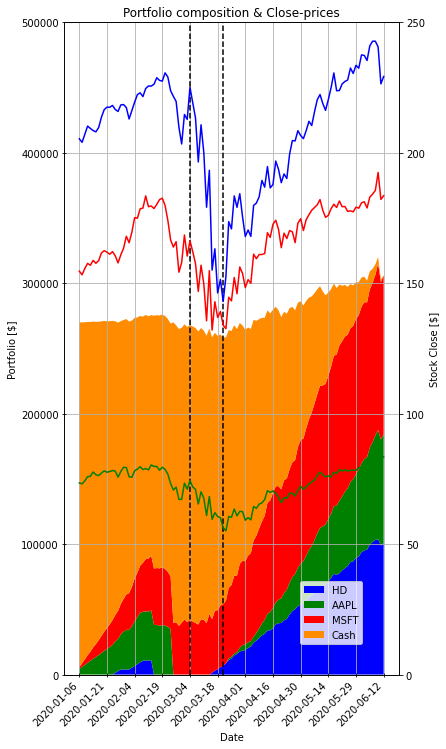

In [ ]:
#COVID-19 Crash Plot unboosted portfolio
logfile=pd.read_csv('/drive/My Drive/OPA/Datasets/logfile_portfolio_12yrs_without_self_adjust.csv')
logfile.drop('Unnamed: 0',axis=1,inplace=True)
portfolio=pd.read_csv('/drive/My Drive/OPA/Datasets/portfolio_portfolio_12yrs_without_self_adjust.csv')

covid_crash_df=logfile[(logfile['Date'] > '2020-01-05') & (logfile['Date'] < '2020-06-15')]

def cov_stack_plot(logfile,tickers,length=10):
  y=[]
  labels=[]
  colors=[]
  color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
  for i,ticker in zip(range(len(tickers)),tickers):
    y.append(logfile[logfile['Stock']==ticker]['Book_value'].values)
    labels.append(ticker)
    colors.append(color_list[i])
  labels.append('Cash')
  colors.append('darkorange')
  x=logfile[logfile['Stock']==tickers[0]]['Date'].values
  y.append(logfile[logfile['Stock']==tickers[0]].reset_index()['Port_total']-logfile.groupby(['Date']).sum().reset_index()['inv_cash_cum'])

  fig,ax1=plt.subplots(figsize=(6,12))
  ax2=ax1.twinx()

  ax1.stackplot(x,y,labels=labels,colors=colors)

  ax2.plot(covid_crash_df[covid_crash_df['Stock']=='HD']['Date'],covid_crash_df[covid_crash_df['Stock']=='HD']['Close'],color='blue')
  ax2.plot(covid_crash_df[covid_crash_df['Stock']=='AAPL']['Date'],covid_crash_df[covid_crash_df['Stock']=='AAPL']['Close'],color='green')
  ax2.plot(covid_crash_df[covid_crash_df['Stock']=='MSFT']['Date'],covid_crash_df[covid_crash_df['Stock']=='MSFT']['Close'],color='red')

  ax1.axvline('2020-03-04',color='black',linestyle='--')
  ax1.axvline('2020-03-20',color='black',linestyle='--')

  ax1.set_ylim(0,5e5)
  ax2.set_ylim(0,250)  
  ax1.set_xticks(x.astype('str')[::length])
  ax1.set_xticklabels(x.astype('str')[::length],rotation=45,ha='right')
  ax1.tick_params(direction='inout')
  ax1.set_xlabel('Date')
  ax1.set_ylabel('Portfolio [$]')
  ax2.set_ylabel('Stock Close [$]')
  ax1.xaxis.grid(True)
  ax1.yaxis.grid(True)
  fig.legend(loc='best',bbox_to_anchor=(0.85,0.2))
  ax1.set_title('Portfolio composition & Close-prices');



cov_stack_plot(covid_crash_df,['HD','AAPL','MSFT'])

In [ ]:
# 11.01.
Code einschicken
Defense: Streamlit (mandatory) / Powerpoint 20 minutes
- Dataviz
- Nicht zu viel über NAs reden
- 

Q&A: 10 Minutes (Gaspard, Jeremy + dritte Person)

Updated Report nächste Woche

Nächstes Treffen: 01.02. 18 Uhr

Streamlit bis 9.2.
Defense 15.2. (steht noch nicht ganz fest)


# Ape on a typewriter comparison (Vergleich mit "showing best combination"

<ipython-input-17-75fd9423b14d>:58: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best',bbox_to_anchor=(0.18,0.88))


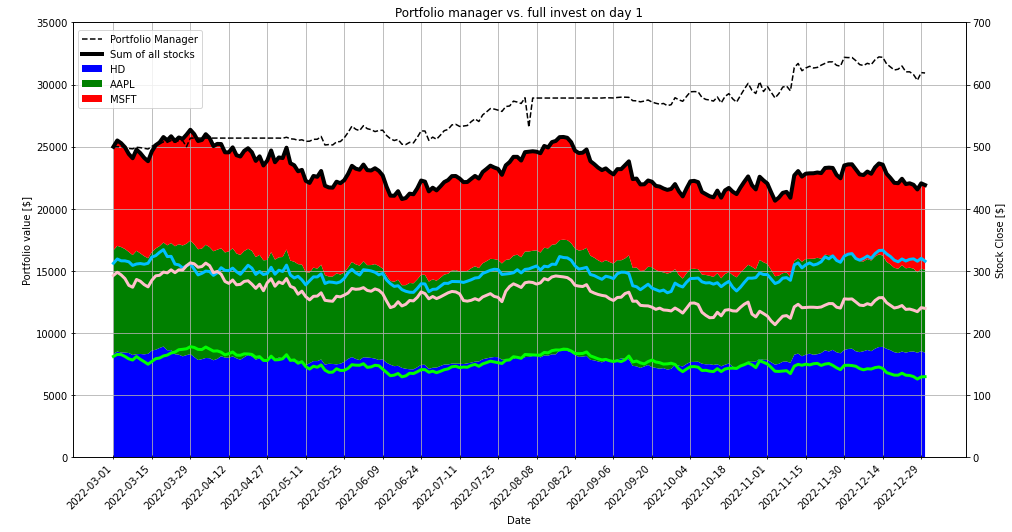

In [ ]:
logfile=pd.read_csv('/drive/My Drive/OPA/Datasets/logfile_portfolio_best_combination_without_self_adjust.csv')
logfile.drop('Unnamed: 0',axis=1,inplace=True)
portfolio=pd.read_csv('/drive/My Drive/OPA/Datasets/portfolio_portfolio_best_combination_without_self_adjust.csv')

for i in logfile.index:
  if logfile.loc[i,'Stock'] == 'MSFT':
    logfile.loc[i,'inv_qty_new']=28.4593
  if logfile.loc[i,'Stock'] == 'HD':
    logfile.loc[i,'inv_qty_new']=26.676
  if logfile.loc[i,'Stock'] == 'AAPL':
    logfile.loc[i,'inv_qty_new']=51.2931

logfile['value_new']=logfile['Close'] * logfile['inv_qty_new']

def cov_stack_plot(logfile,tickers,length=10):
  y=[]
  labels=[]
  colors=[]
  color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
  for i,ticker in zip(range(len(tickers)),tickers):
    y.append(logfile[logfile['Stock']==ticker]['value_new'].values)
    labels.append(ticker)
    colors.append(color_list[i])

  x=logfile[logfile['Stock']==tickers[0]]['Date'].values

  fig,ax1=plt.subplots(figsize=(16,8))

  y3=logfile[logfile['Stock']==tickers[0]].reset_index()['Port_total']-logfile.groupby(['Date']).sum().reset_index()['inv_cash_cum']
  label4="Book Value"
  y4=logfile.groupby(['Date']).sum().reset_index()['Book_value']+y3

  my_list = np.array(y)
  sum_y=np.sum(my_list,axis=0)

  ax1.stackplot(x,y,labels=labels,colors=colors)
  ax1.plot(x,y4,color='black',label='Portfolio Manager',linestyle='--')
  ax1.plot(x,sum_y,color='black',label='Sum of all stocks',linewidth=4)
  ax2=ax1.twinx()

  ax2.plot(logfile[logfile['Stock']=='HD']['Date'],logfile[logfile['Stock']=='HD']['Close'],color='deepskyblue',linewidth=3)
  ax2.plot(logfile[logfile['Stock']=='AAPL']['Date'],logfile[logfile['Stock']=='AAPL']['Close'],color='lime',linewidth=3)
  ax2.plot(logfile[logfile['Stock']=='MSFT']['Date'],logfile[logfile['Stock']=='MSFT']['Close'],color='pink',linewidth=3)
  ax2.set_ylim(0,700)

  ax1.set_ylim(0,35000)
  ax1.set_xticks(x.astype('str')[::length])
  ax1.set_xticklabels(x.astype('str')[::length],rotation=45,ha='right')
  ax1.set_yticks(np.arange(0,40000,5000))
  ax1.tick_params(direction='inout')
  ax1.set_xlabel('Date')
  ax1.set_ylabel('Portfolio value [$]')
  ax2.set_ylabel('Stock Close [$]')
  ax1.xaxis.grid(True)
  ax1.yaxis.grid(True)
  fig.legend(loc='best',bbox_to_anchor=(0.18,0.88))
  ax1.set_title('Portfolio manager vs. full invest on day 1');

cov_stack_plot(logfile,['HD','AAPL','MSFT'])